In [4]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU, DCRNN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

import matplotlib.pyplot as plt
import os

FILE_NAME='/Users/scini/Documents/GitHub/Initiator_Cell_GNN_Development/Attempts_with_Calcium/ca_data_pygt_dataset.pt'
dataset = torch.load(FILE_NAME)


train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# Visualize training and testing split
print("Number of training snapshots: {}".format(train_dataset.snapshot_count))
print("Number of testing snapshots: {}".format(test_dataset.snapshot_count))

Number of training snapshots: 2880
Number of testing snapshots: 720


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_51708/1174991555.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(FILE_NAME)


In [15]:


class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
        
model = RecurrentGCN(node_features = 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
mse_per_epoch = []

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat - snapshot.y) ** 2)
    cost = cost / (time + 1)
    mse_per_epoch.append(cost.item())  # Store cost at each iteration
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Final train cost: {:.4f}".format(cost.item()))

    
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))


  2%|▏         | 2/100 [00:05<04:44,  2.90s/it]


KeyboardInterrupt: 

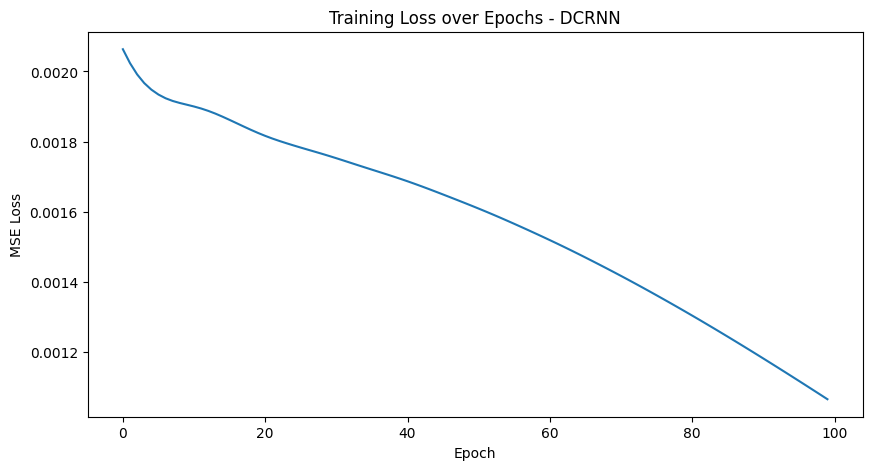

In [14]:
# plot mse loss per epoch
plt.figure(figsize=(10,5))
plt.plot(range(len(mse_per_epoch)), mse_per_epoch)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Training Loss over Epochs - DCRNN")
plt.show()


In [9]:
model.eval()
cost = 0
cost_per_time = []
len_test = test_dataset.snapshot_count
print("Number of snapshots in test dataset: {}".format(len_test))
for time, snapshot in enumerate(test_dataset[0:len_test-1]):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time.append(torch.mean((y_hat - snapshot.y) ** 2).item())  # Store cost at each iteration
    print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time[-1]))
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))


Number of snapshots in test dataset: 720
Time 000 | Test Cost: 0.0000
Time 001 | Test Cost: 0.0000
Time 002 | Test Cost: 0.0000
Time 003 | Test Cost: 0.0000
Time 004 | Test Cost: 0.0000
Time 005 | Test Cost: 0.0000
Time 006 | Test Cost: 0.0000
Time 007 | Test Cost: 0.0000
Time 008 | Test Cost: 0.0000
Time 009 | Test Cost: 0.0000
Time 010 | Test Cost: 0.0000
Time 011 | Test Cost: 0.0000
Time 012 | Test Cost: 0.0000
Time 013 | Test Cost: 0.0000
Time 014 | Test Cost: 0.0000
Time 015 | Test Cost: 0.0000
Time 016 | Test Cost: 0.0000
Time 017 | Test Cost: 0.0000
Time 018 | Test Cost: 0.0000
Time 019 | Test Cost: 0.0000
Time 020 | Test Cost: 0.0000
Time 021 | Test Cost: 0.0000
Time 022 | Test Cost: 0.0000
Time 023 | Test Cost: 0.0000
Time 024 | Test Cost: 0.0000
Time 025 | Test Cost: 0.0000
Time 026 | Test Cost: 0.0000
Time 027 | Test Cost: 0.0000
Time 028 | Test Cost: 0.0000
Time 029 | Test Cost: 0.0000
Time 030 | Test Cost: 0.0000
Time 031 | Test Cost: 0.0000
Time 032 | Test Cost: 0.0000
Ti

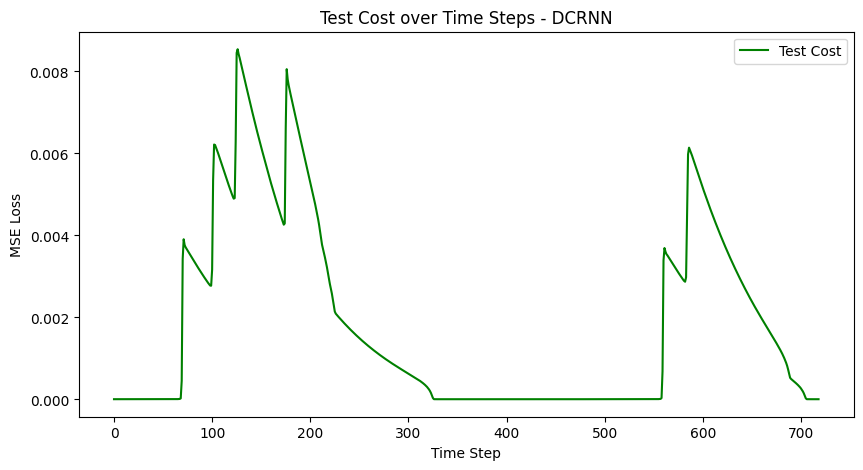

In [13]:
plt.figure(figsize=(10,5))
plt.plot(cost_per_time, label='Test Cost', color='green')
plt.xlabel('Time Step')
plt.ylabel('MSE Loss')
plt.title('Test Cost over Time Steps - DCRNN')
plt.legend()
plt.show()

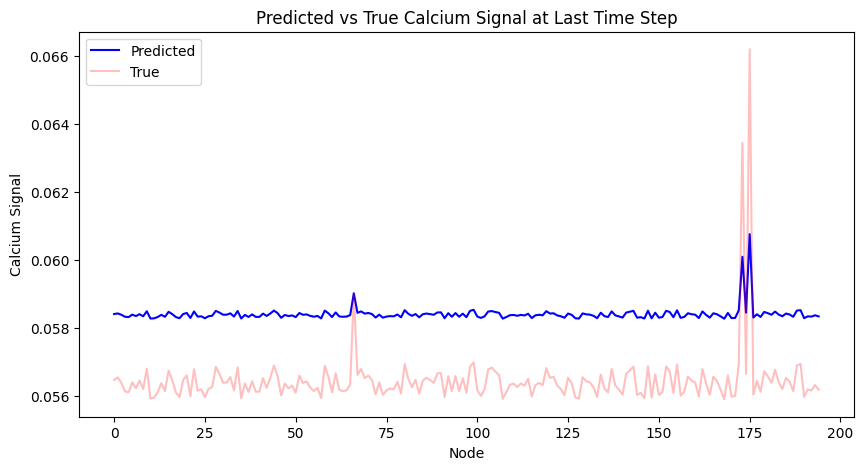

In [10]:
# Plot snapshot of predictions vs true values for the last time step
plt.figure(figsize=(10,5))
plt.plot(y_hat.detach().numpy(), label='Predicted', color='blue')
plt.plot(snapshot.y.detach().numpy(), label='True', color='red', alpha=0.25)
plt.xlabel('Node')
plt.ylabel('Calcium Signal')
plt.title('Predicted vs True Calcium Signal at Last Time Step')
plt.legend()
plt.show()

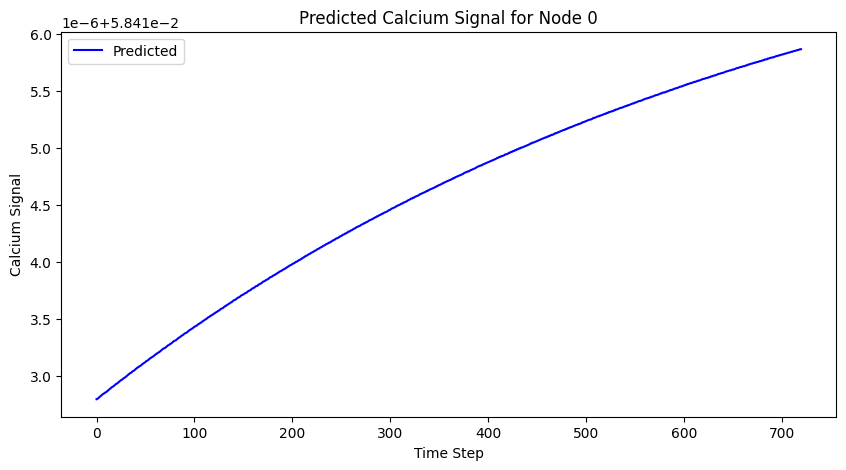

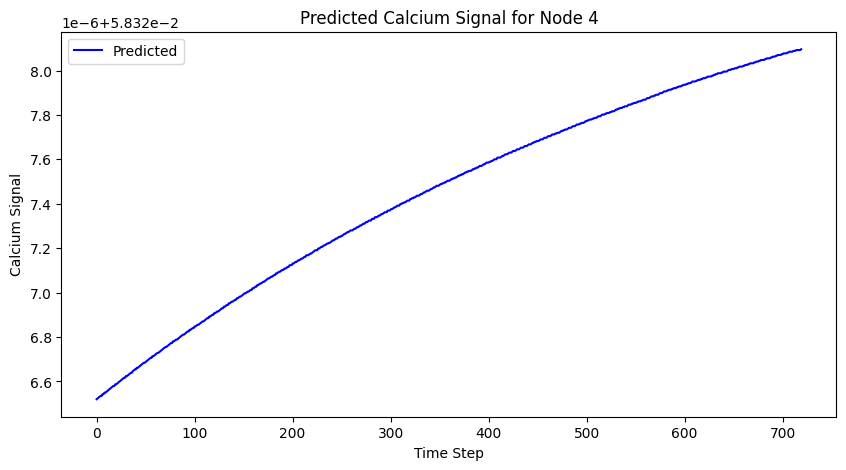

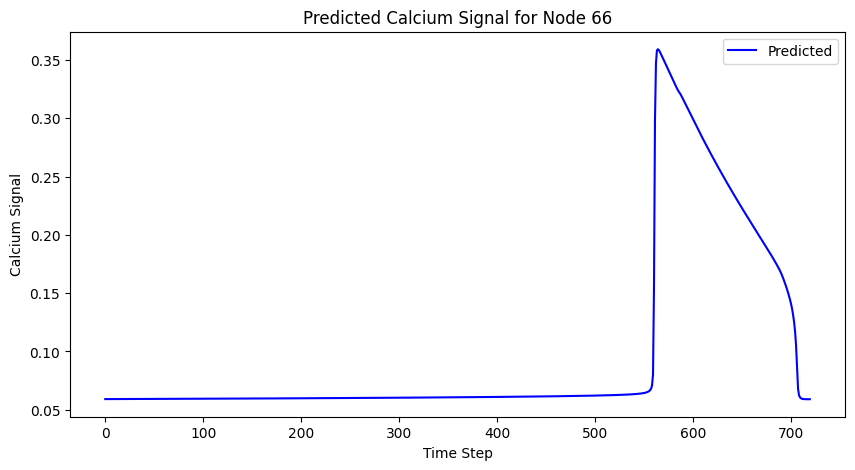

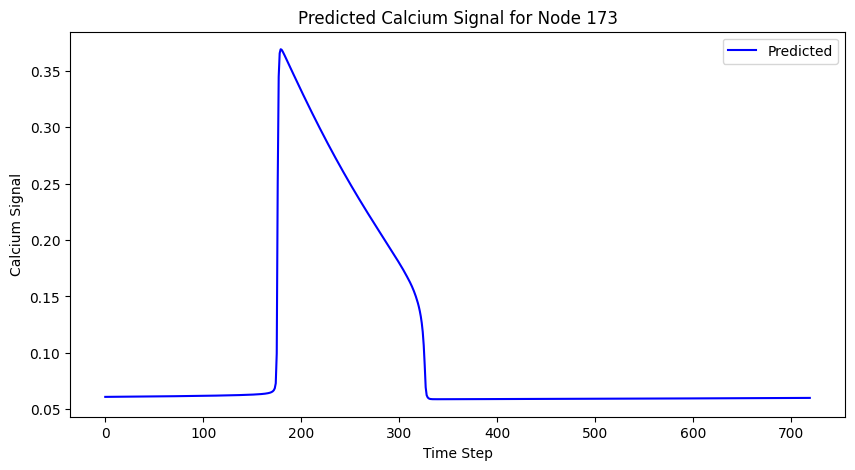

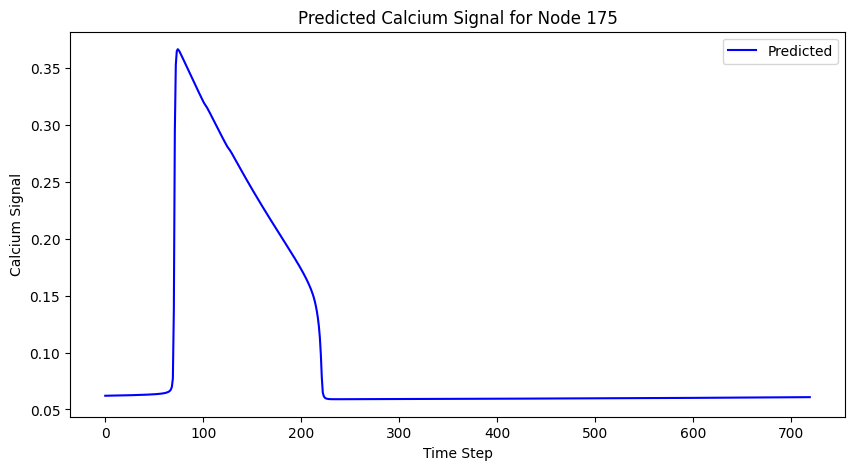

In [12]:
node_ids = [0, 4, 66, 173, 175]

for node_id in node_ids:
    # Plot time series for a specific
    model.eval()
    predictions = []
    true_values = []
    for time, snapshot in enumerate(test_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        predictions.append(y_hat[node_id])
        # true_values.append(snapshot.y[node_id])

    # convert to numpy arrays for plotting
    predictions = torch.stack(predictions).detach().cpu().numpy()
    # true_values = torch.stack(true_values).detach().cpu().numpy()
    plt.figure(figsize=(10,5))
    plt.plot(predictions, label='Predicted', color='blue')
    # plt.plot(true_values.numpy(), label='True', color='red', alpha=0.25)
    plt.xlabel('Time Step')
    plt.ylabel('Calcium Signal')
    plt.title(f'Predicted Calcium Signal for Node {node_id}')
    plt.legend()
    plt.show()

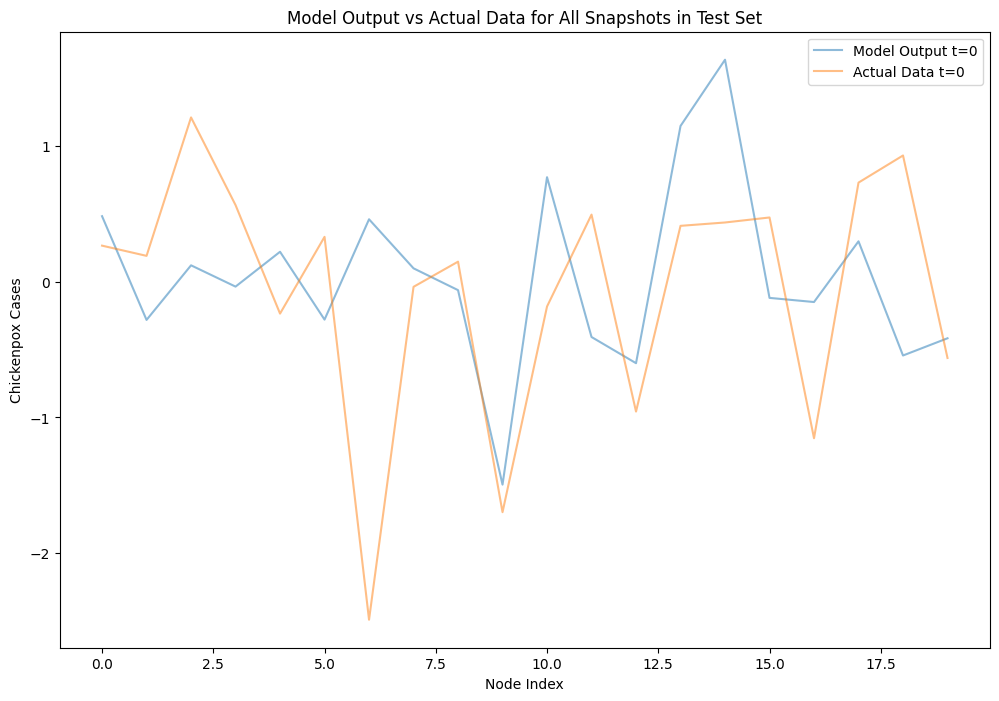

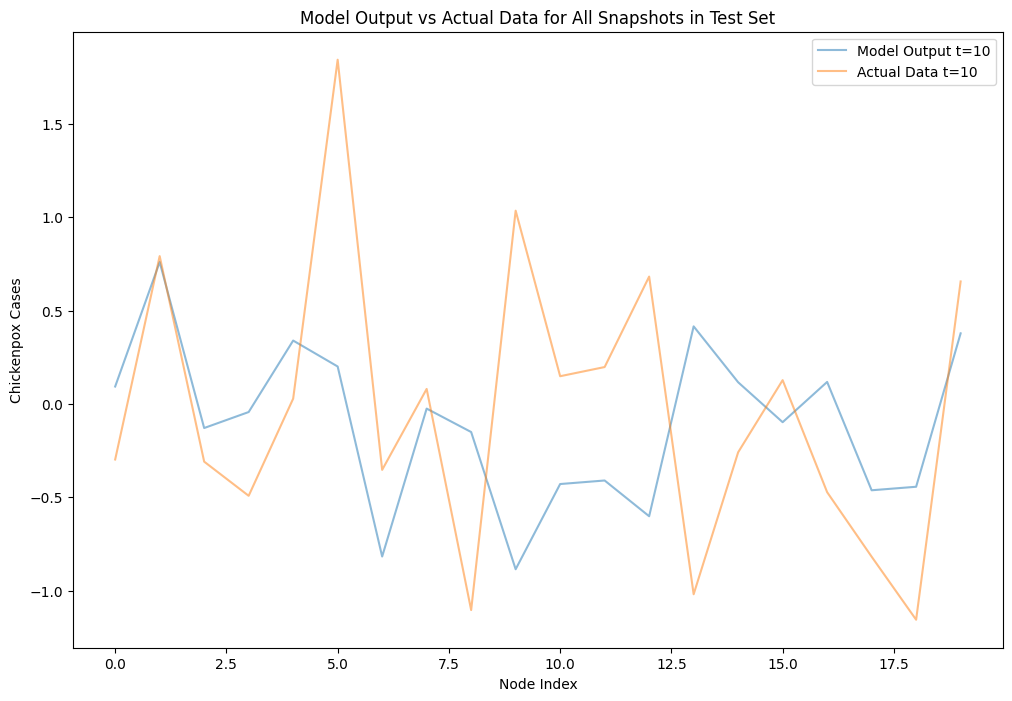

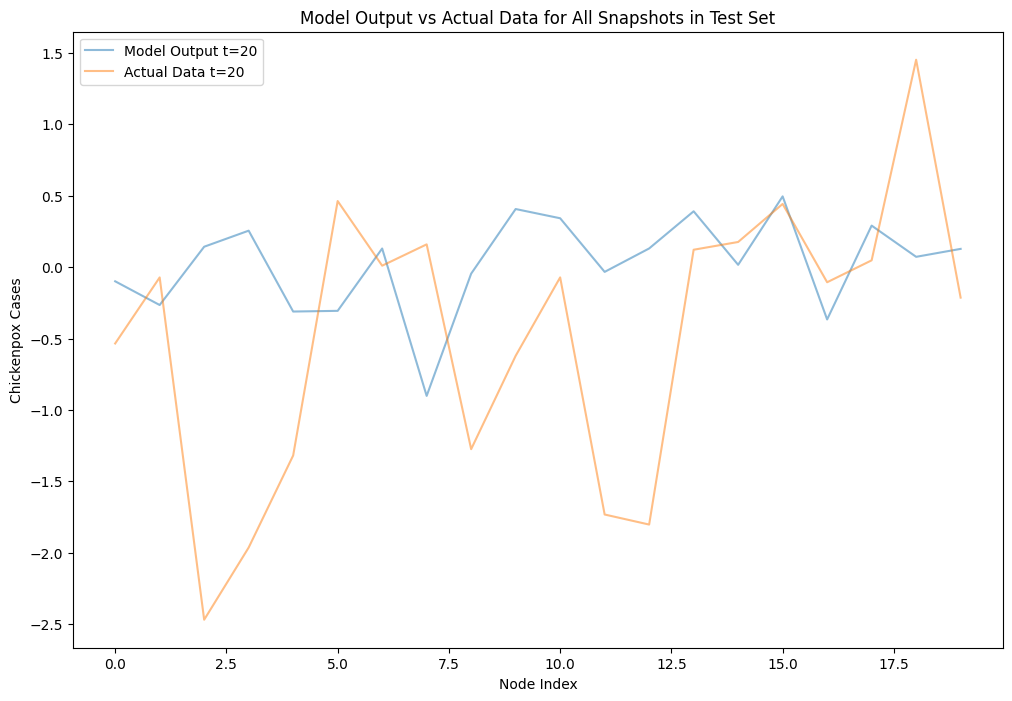

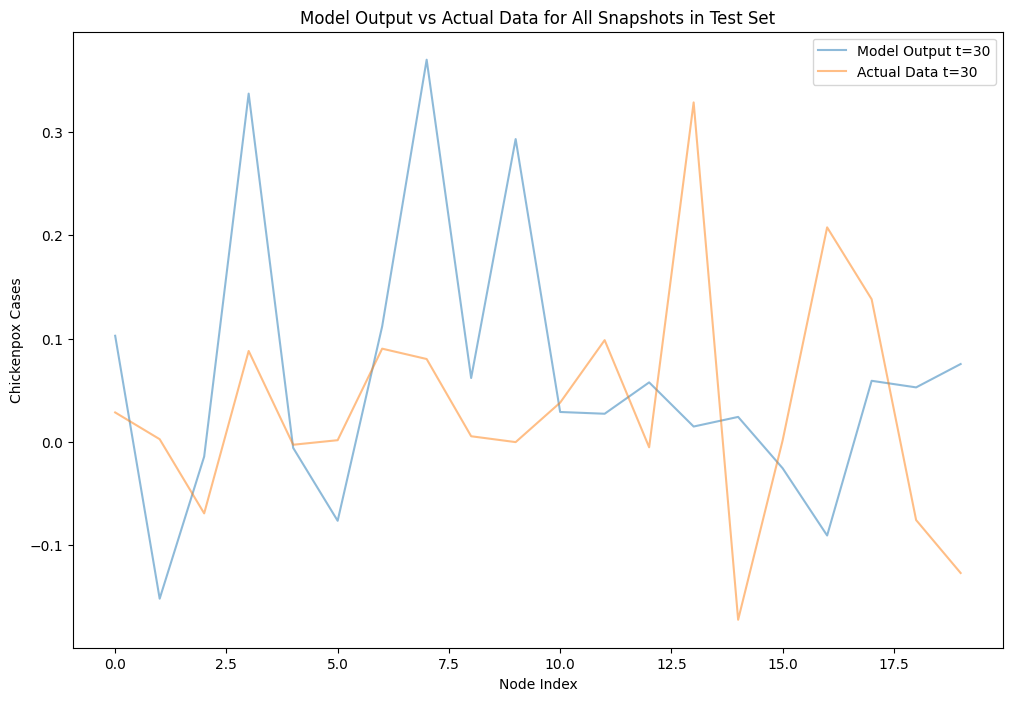

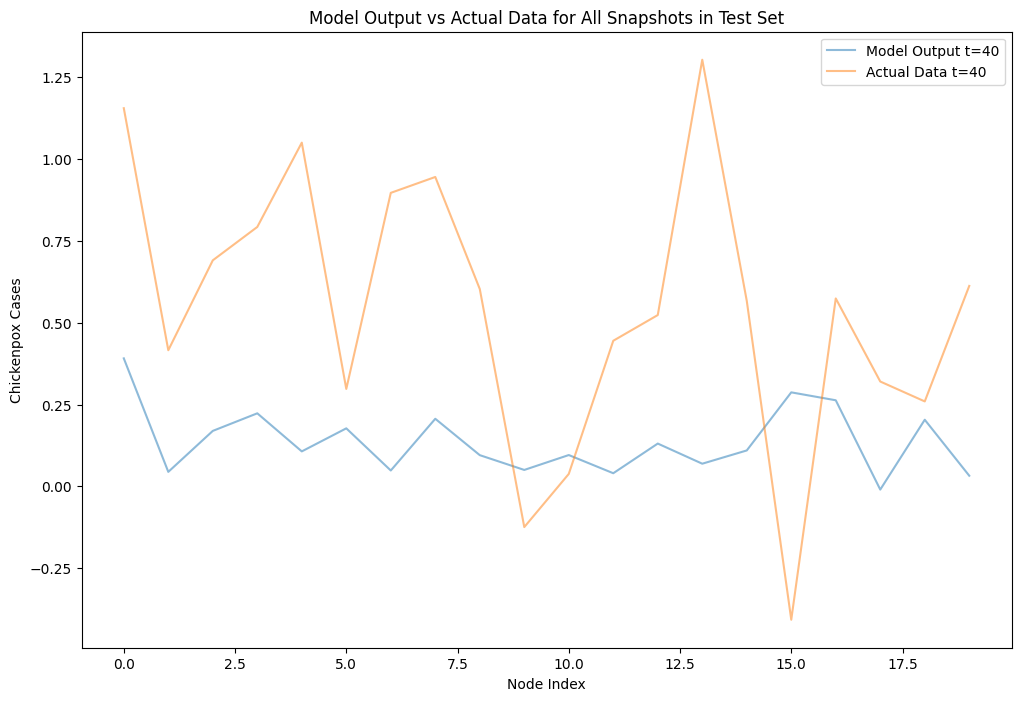

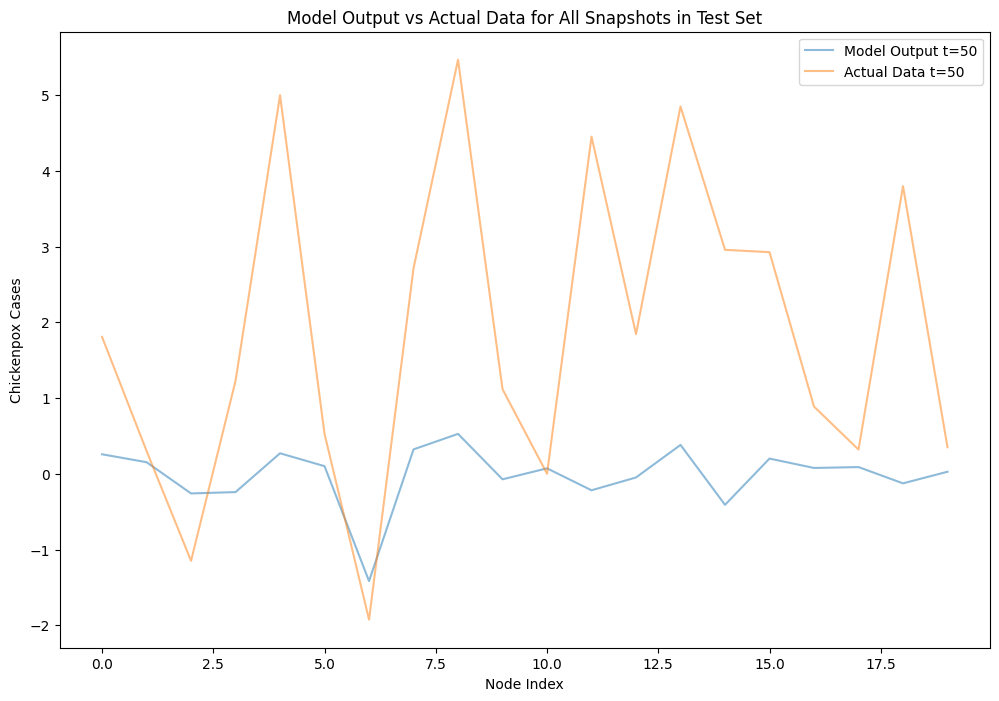

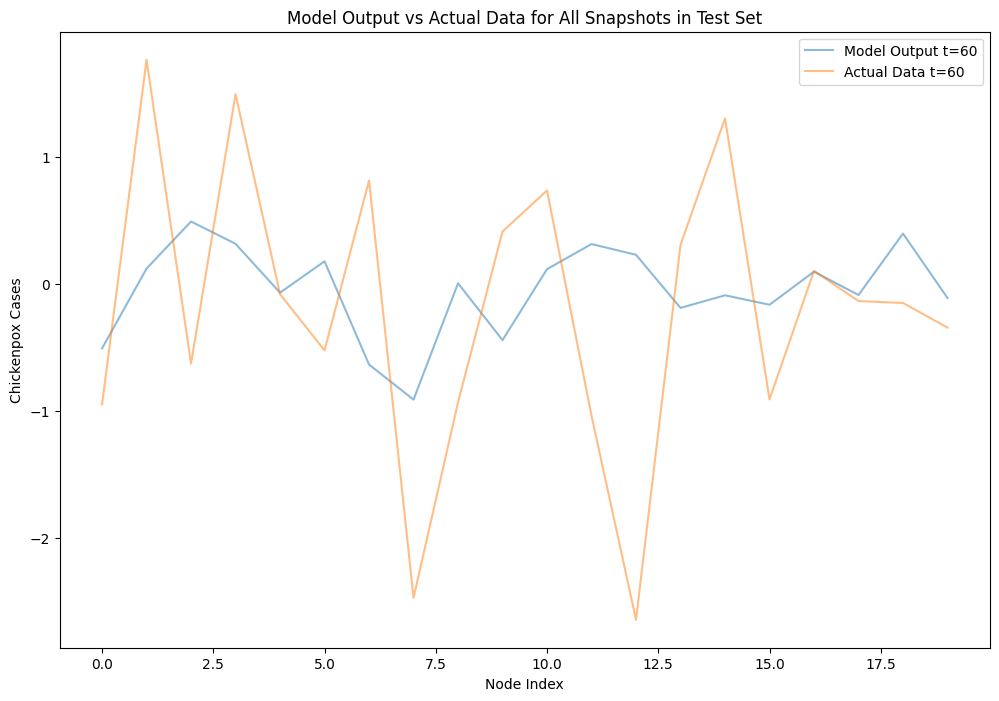

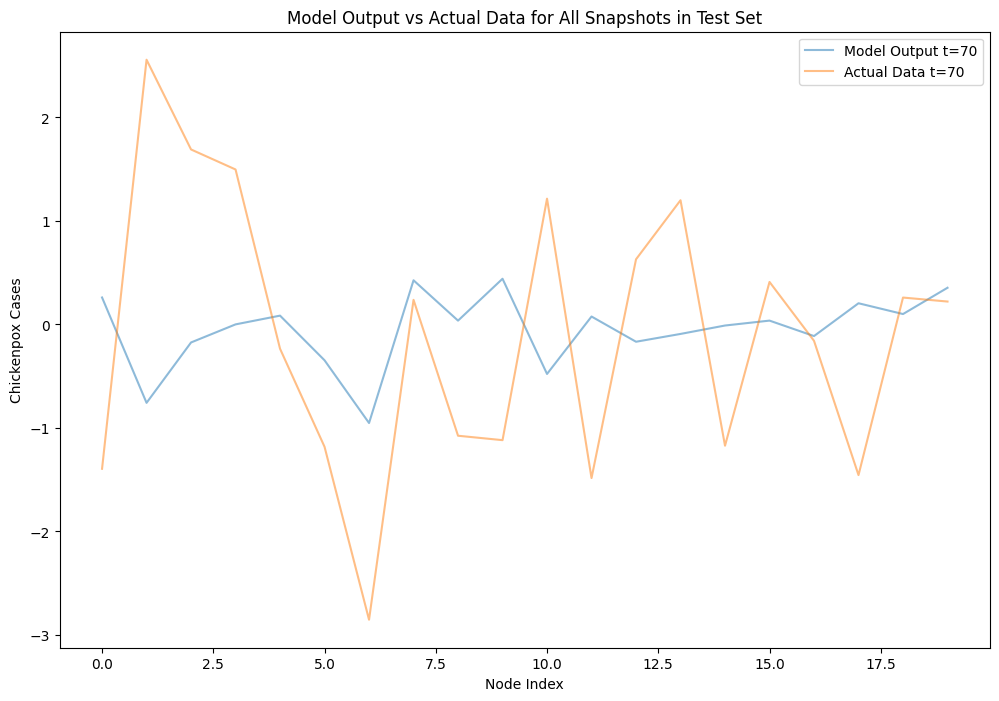

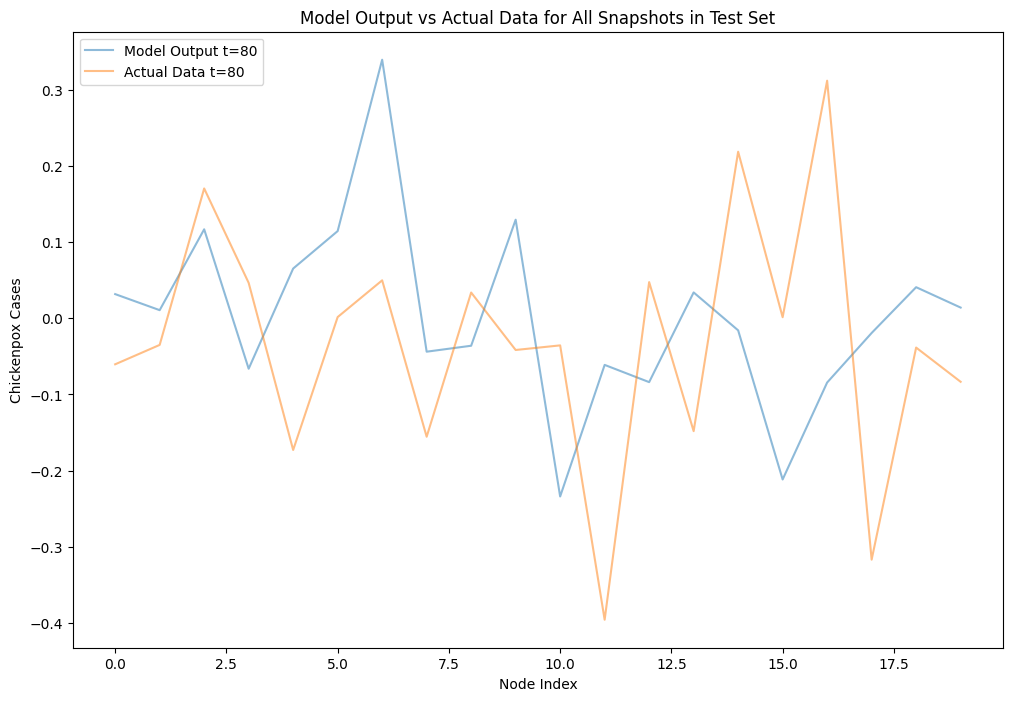

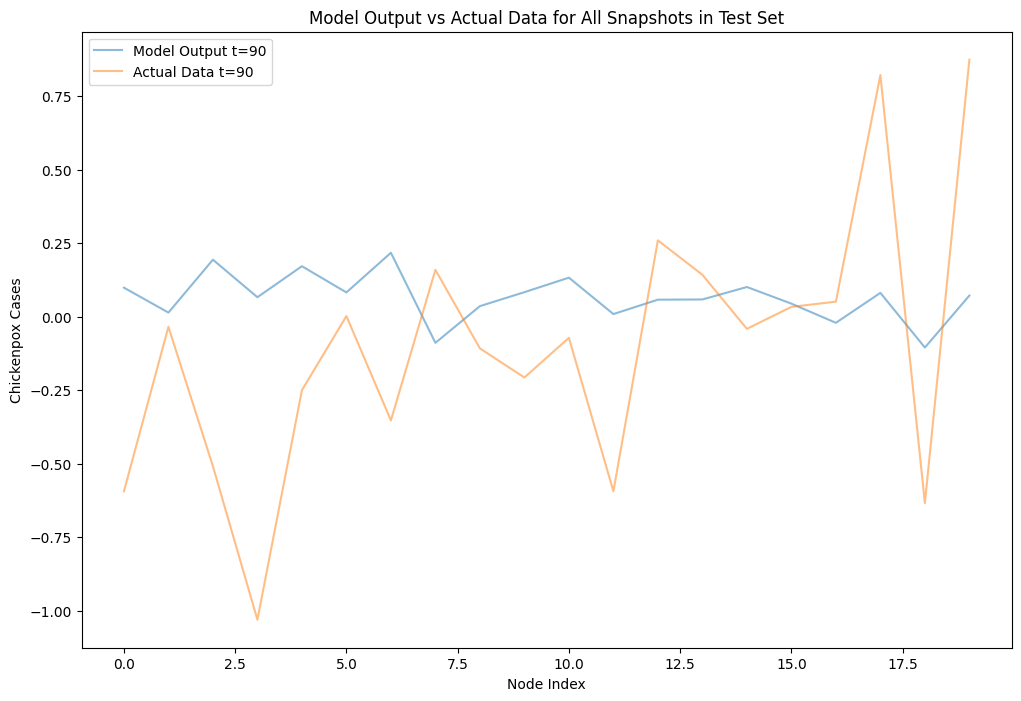

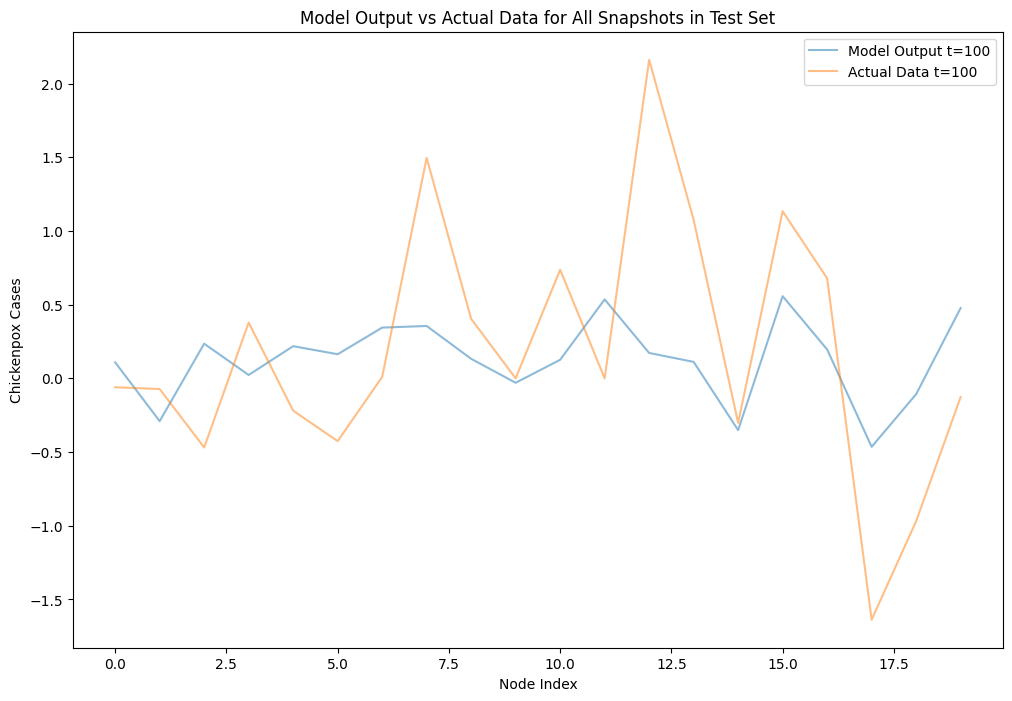

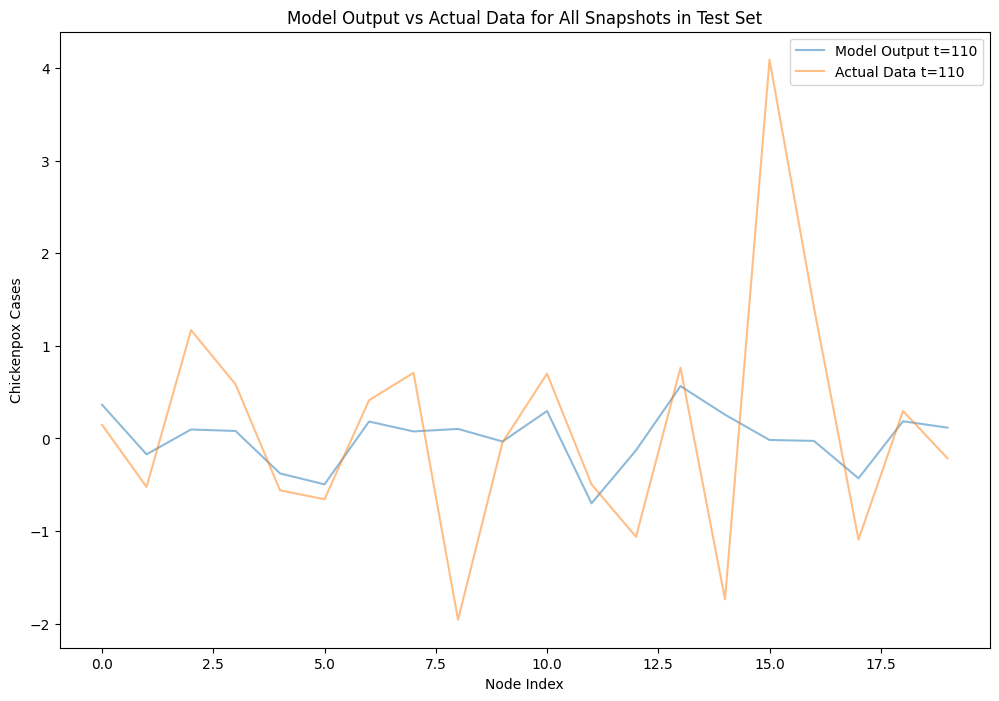

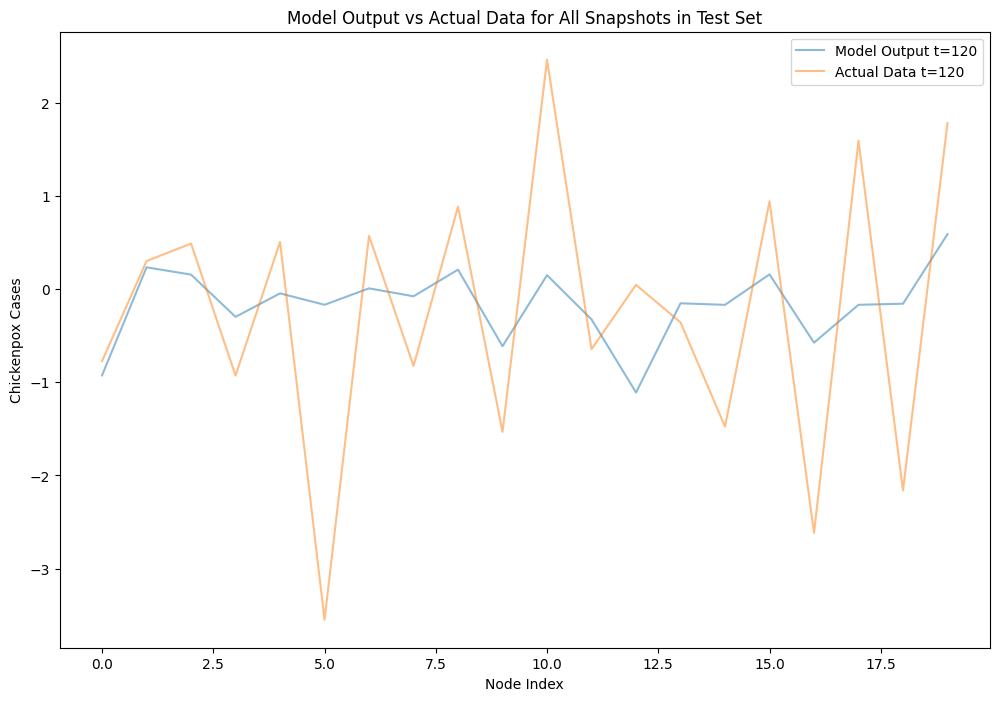

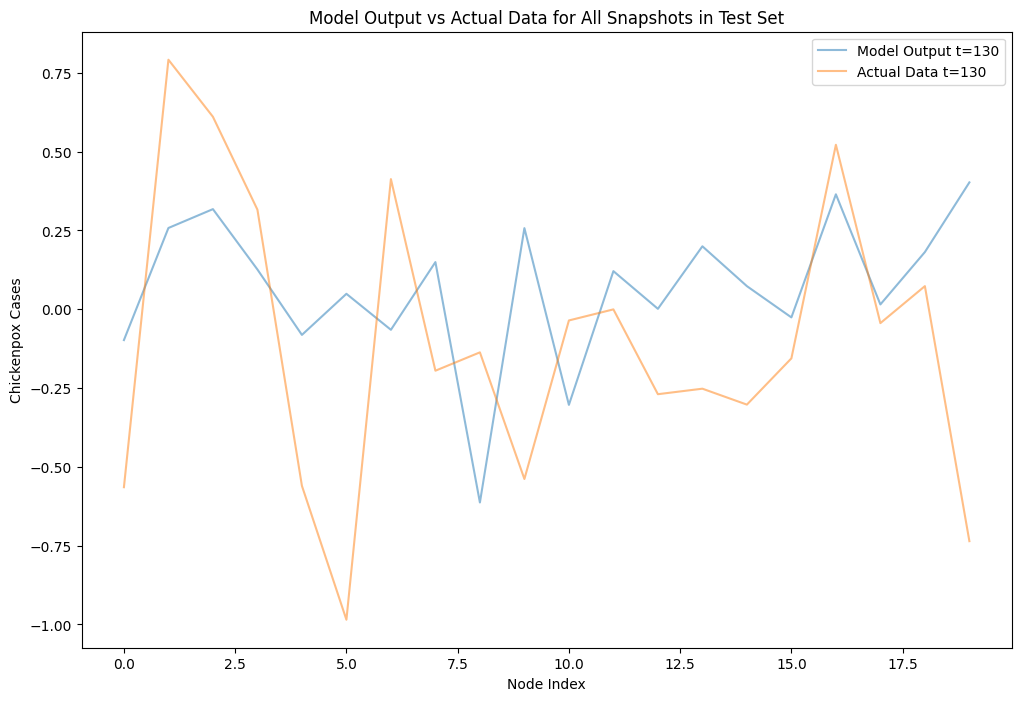

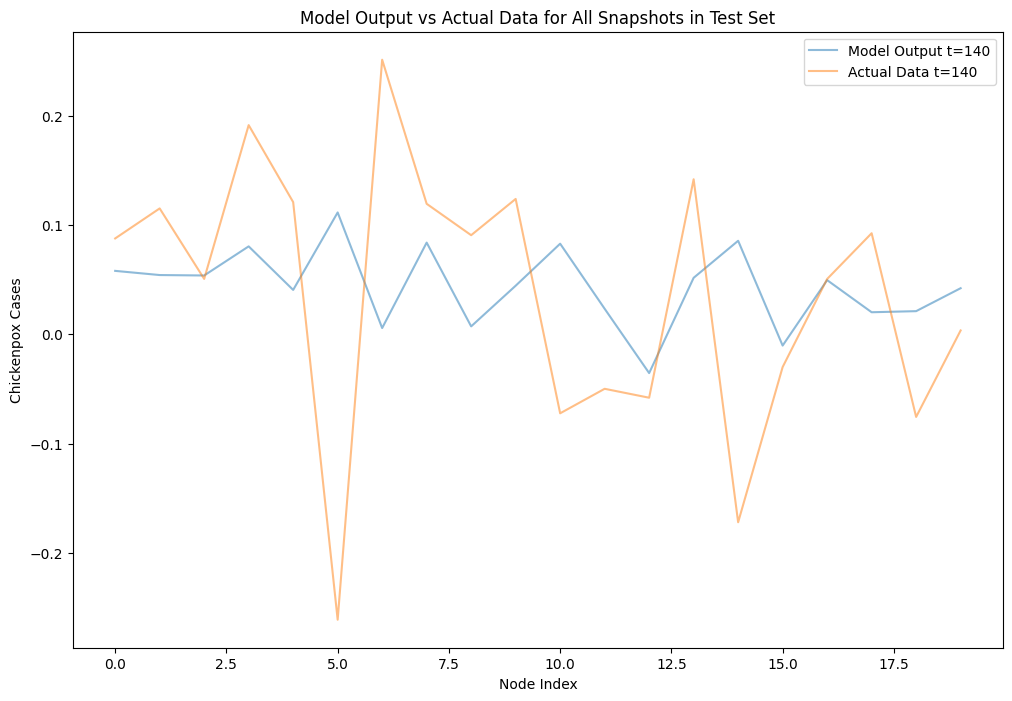

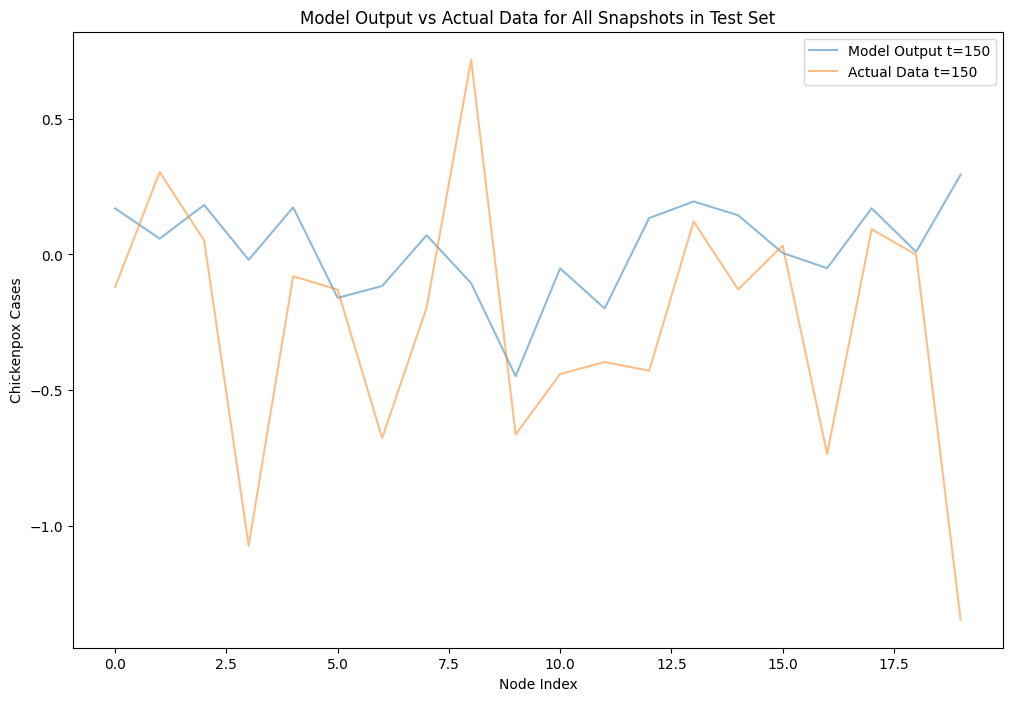

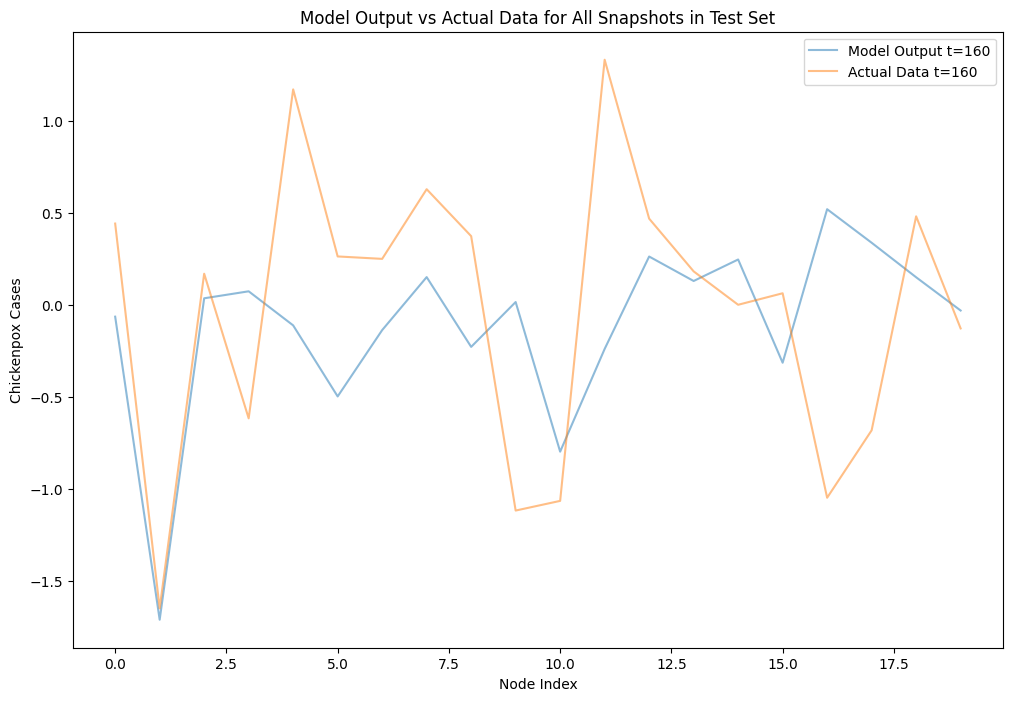

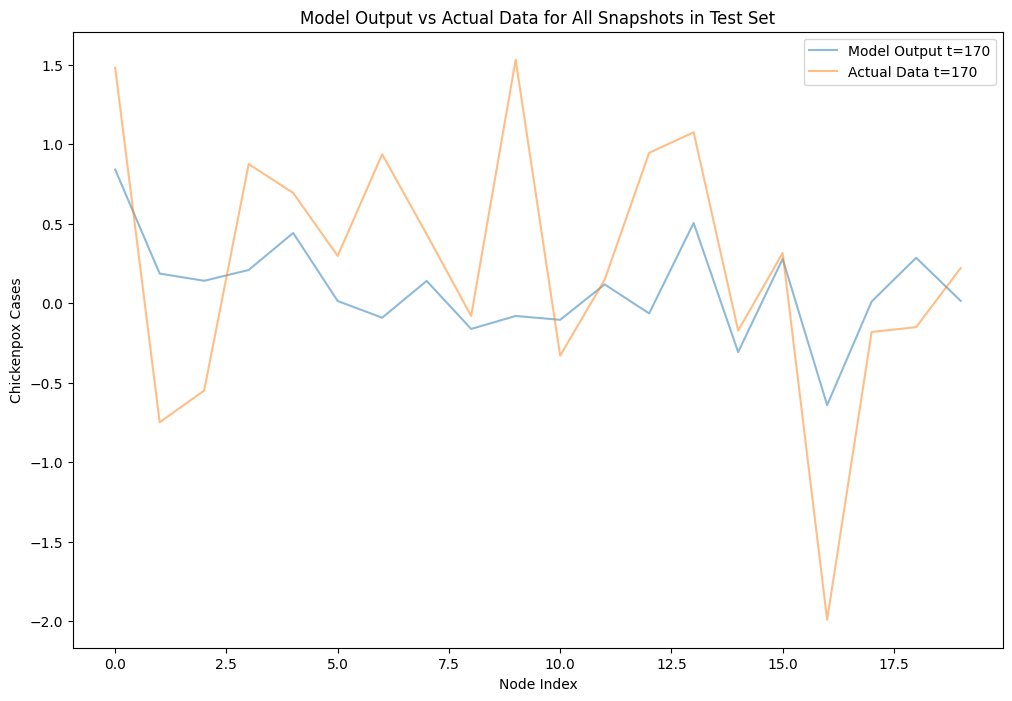

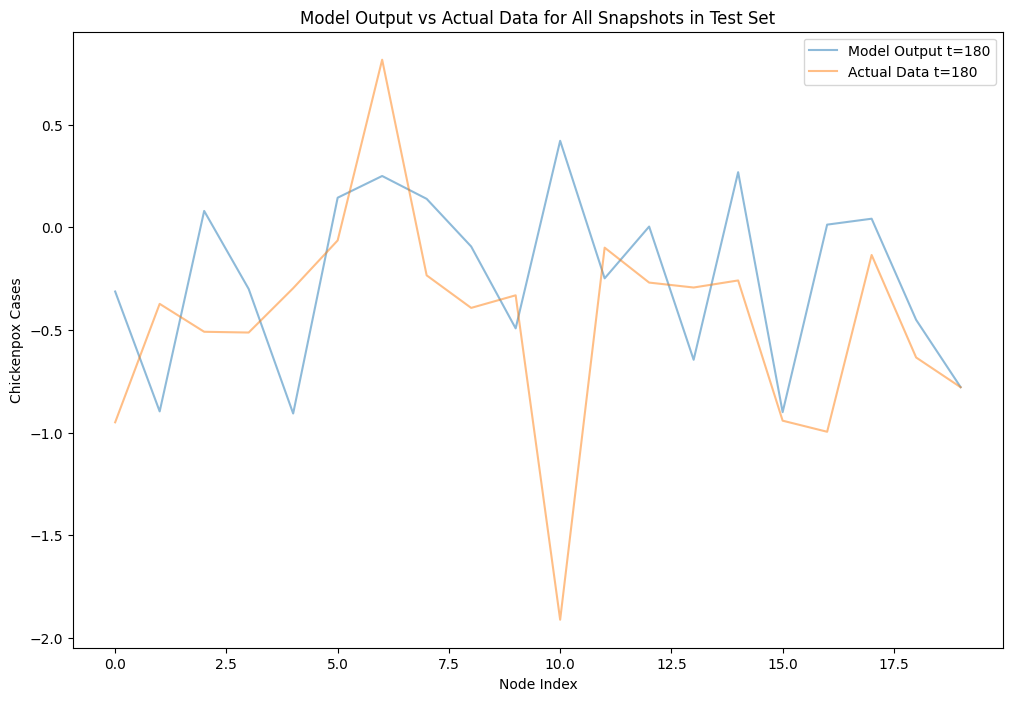

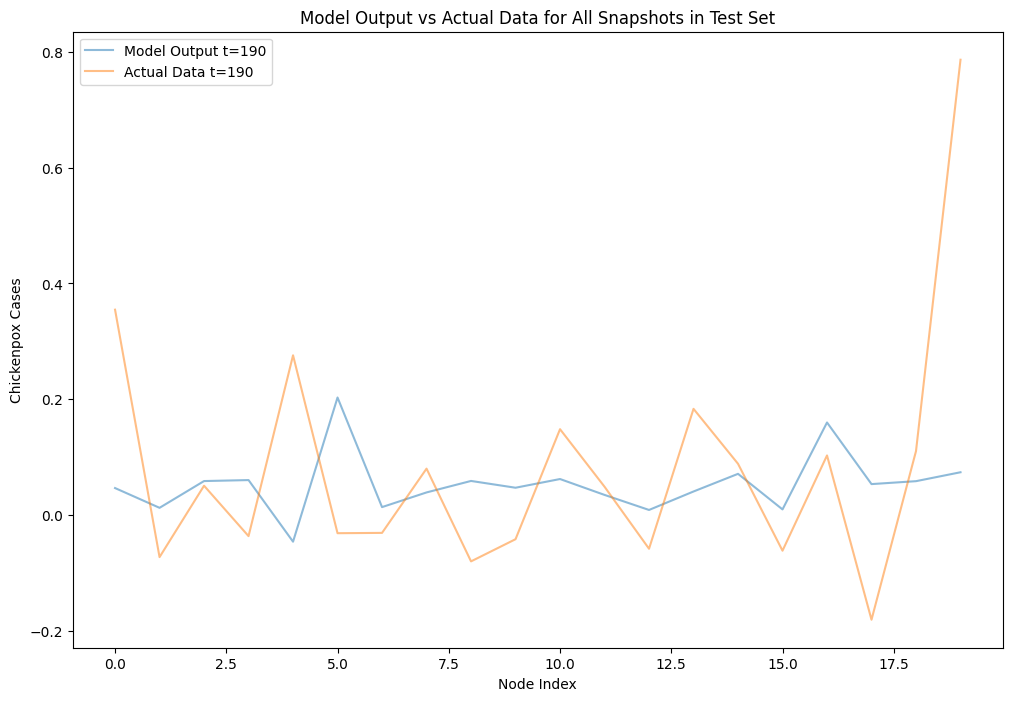

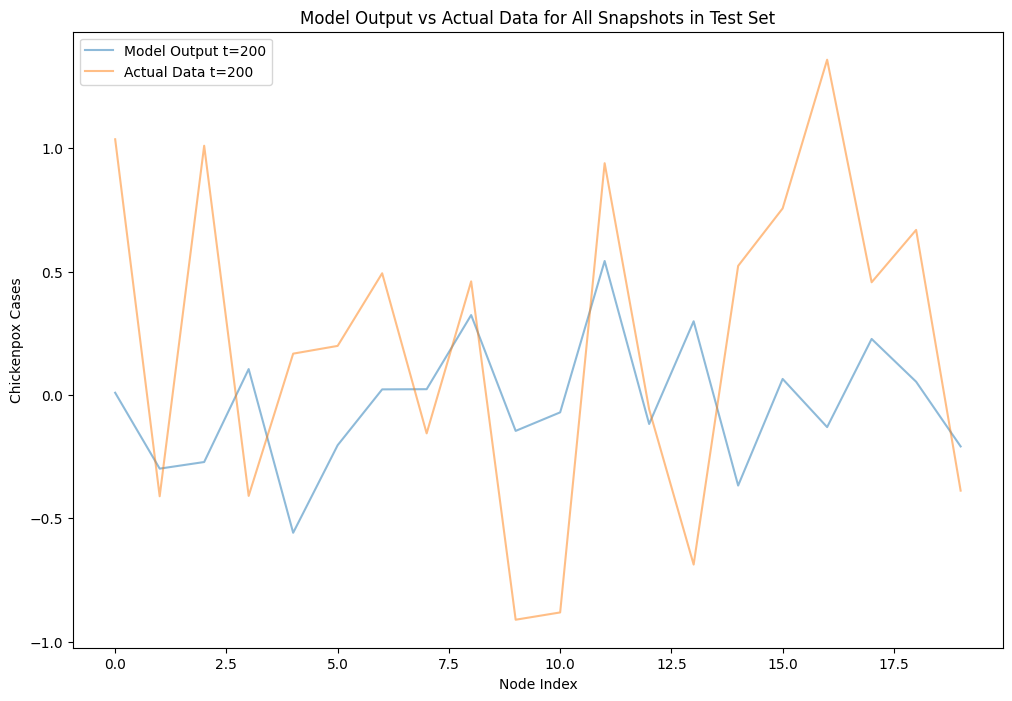

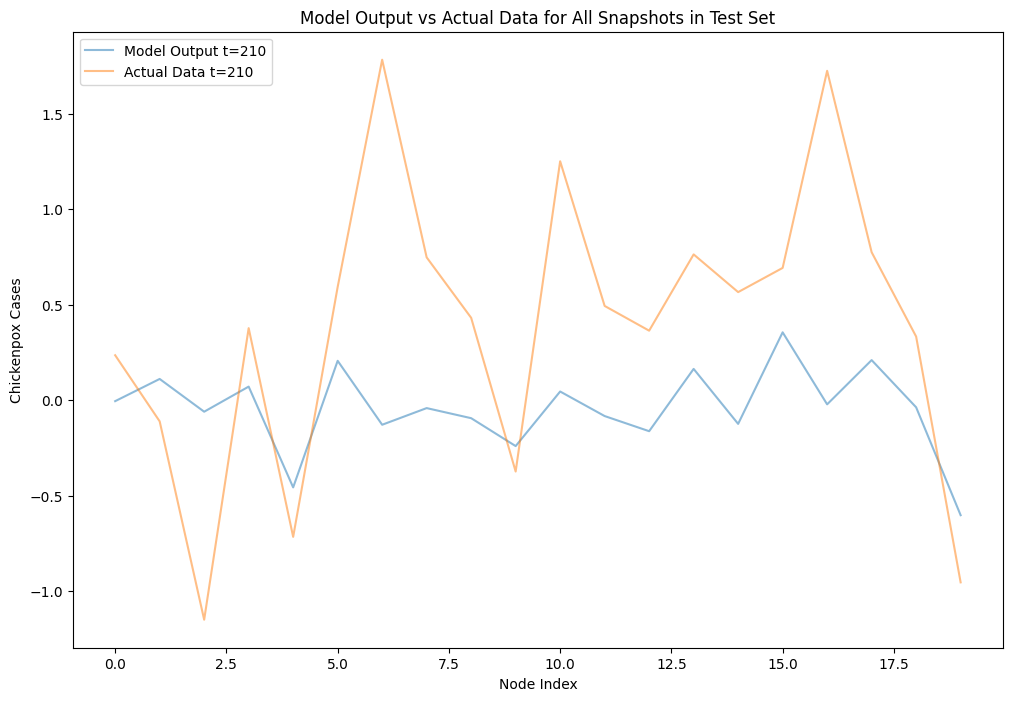

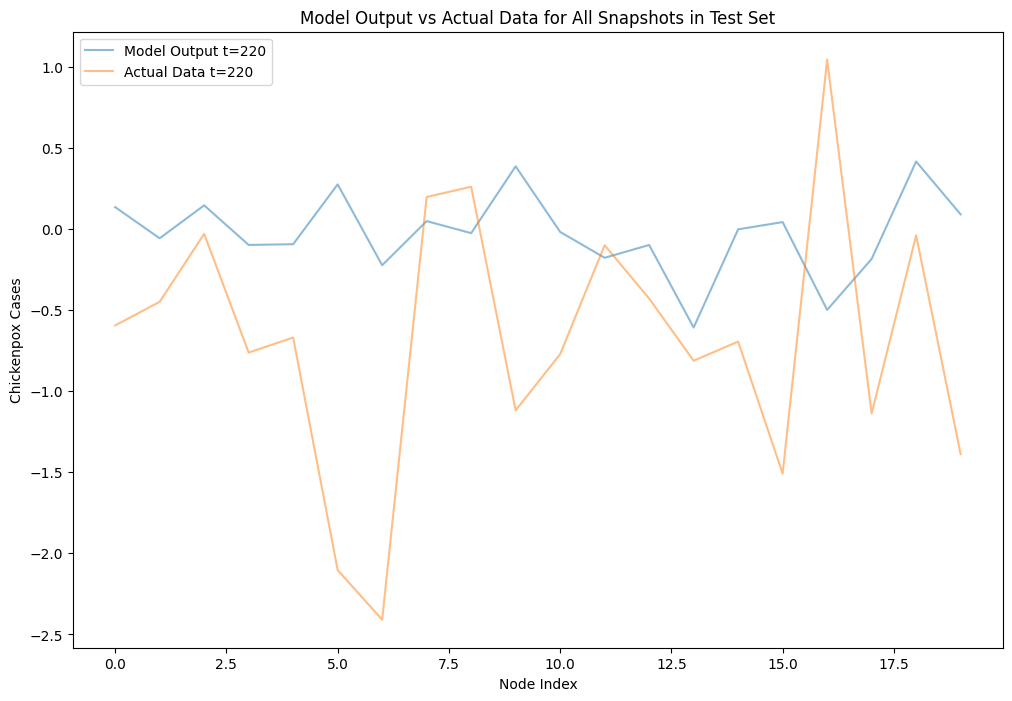

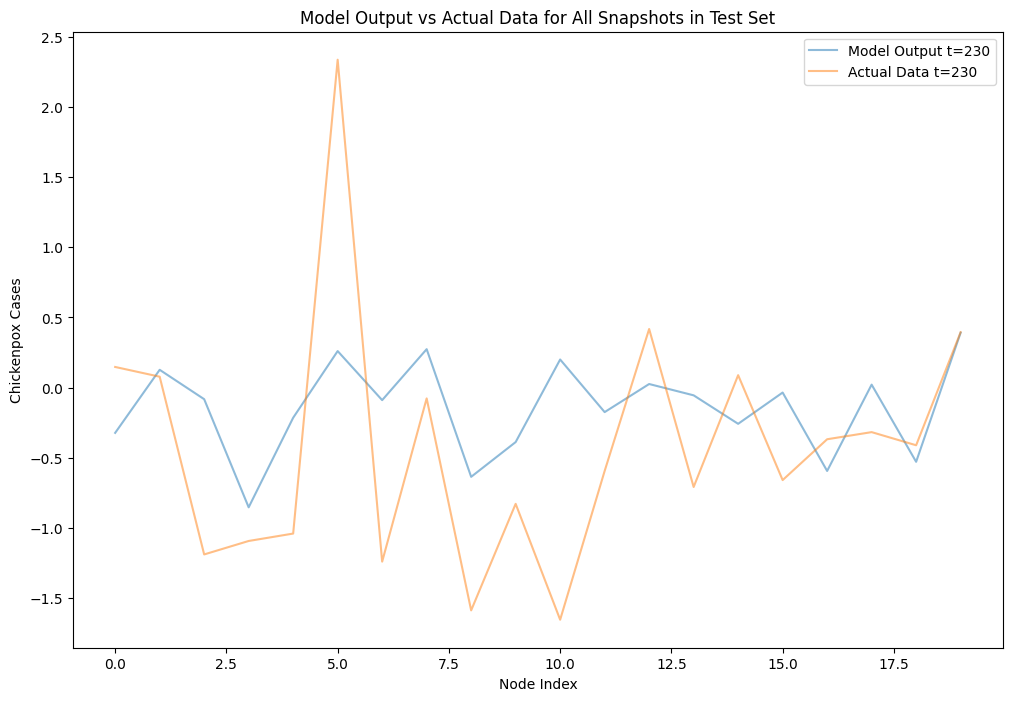

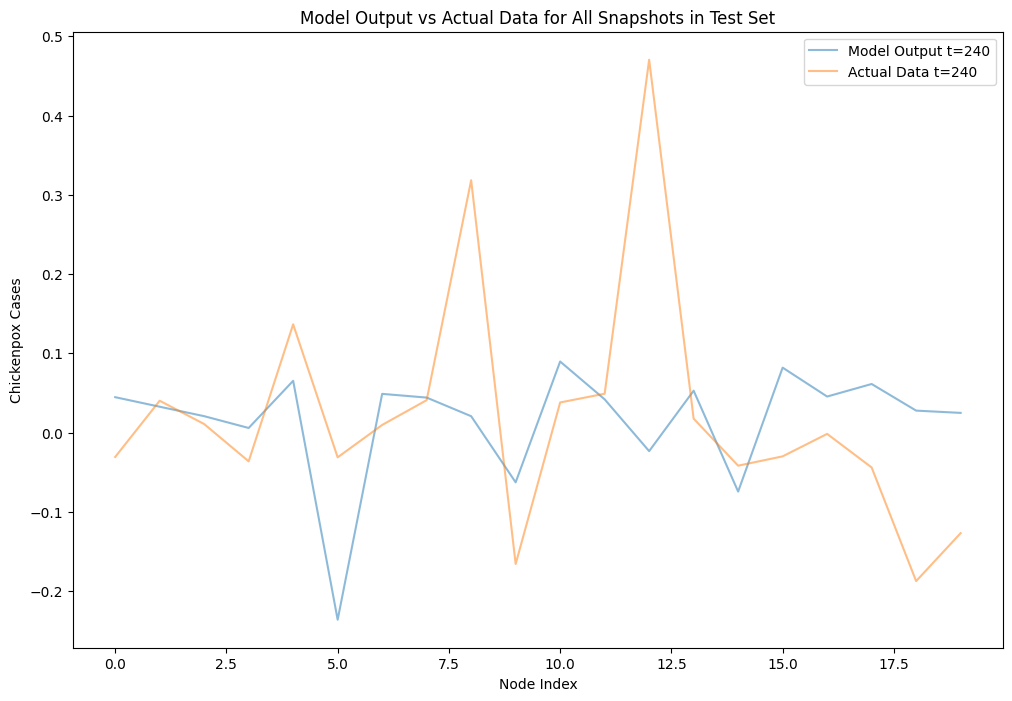

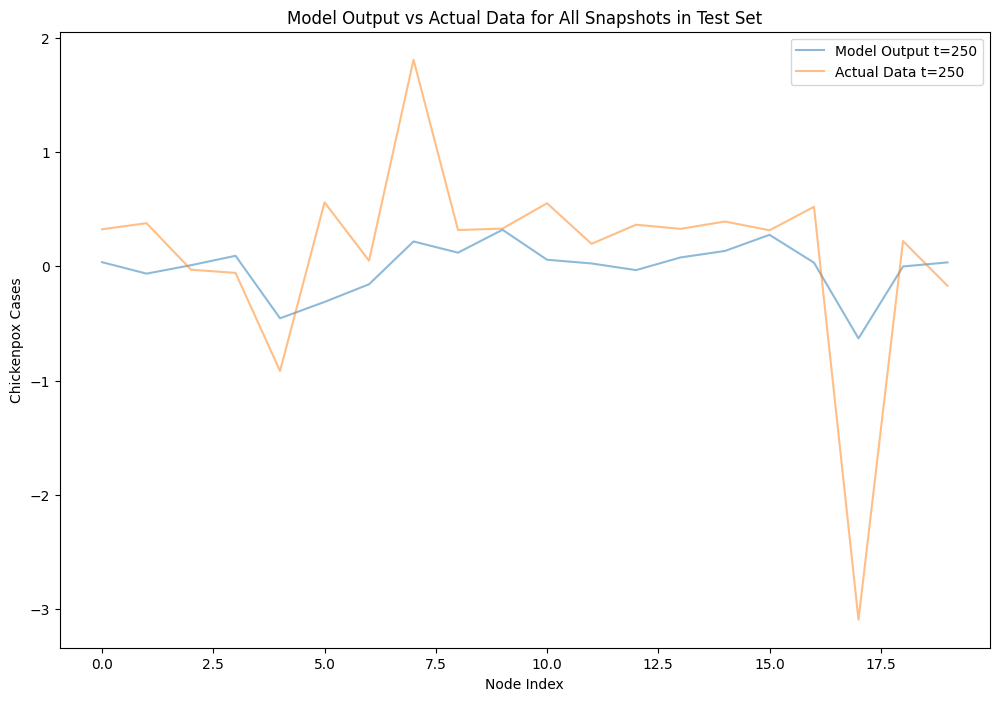

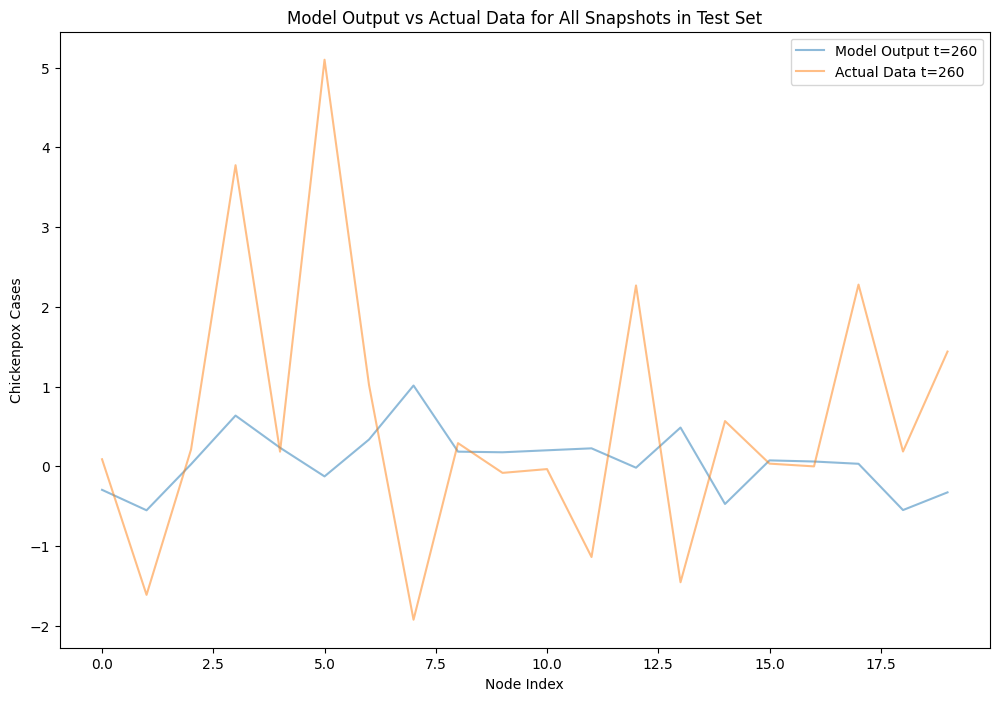

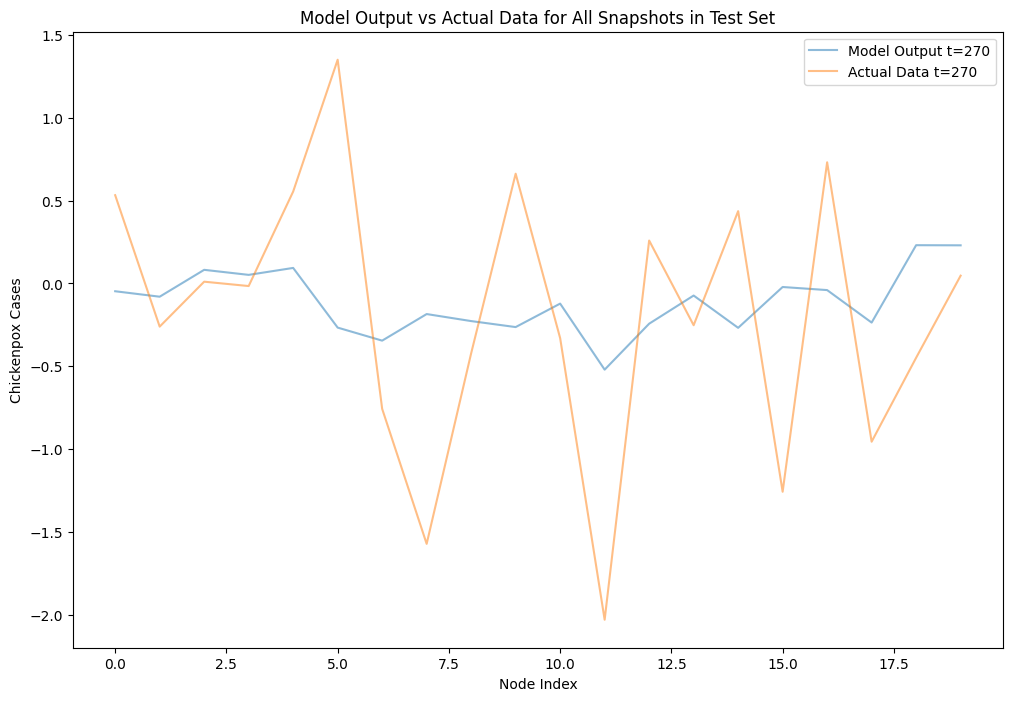

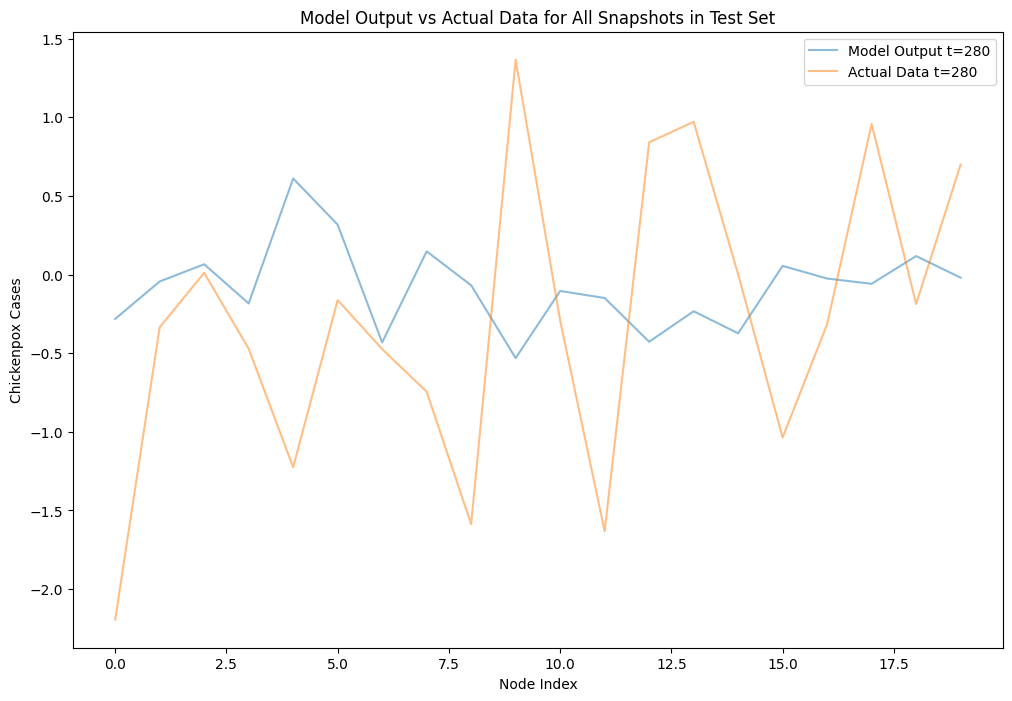

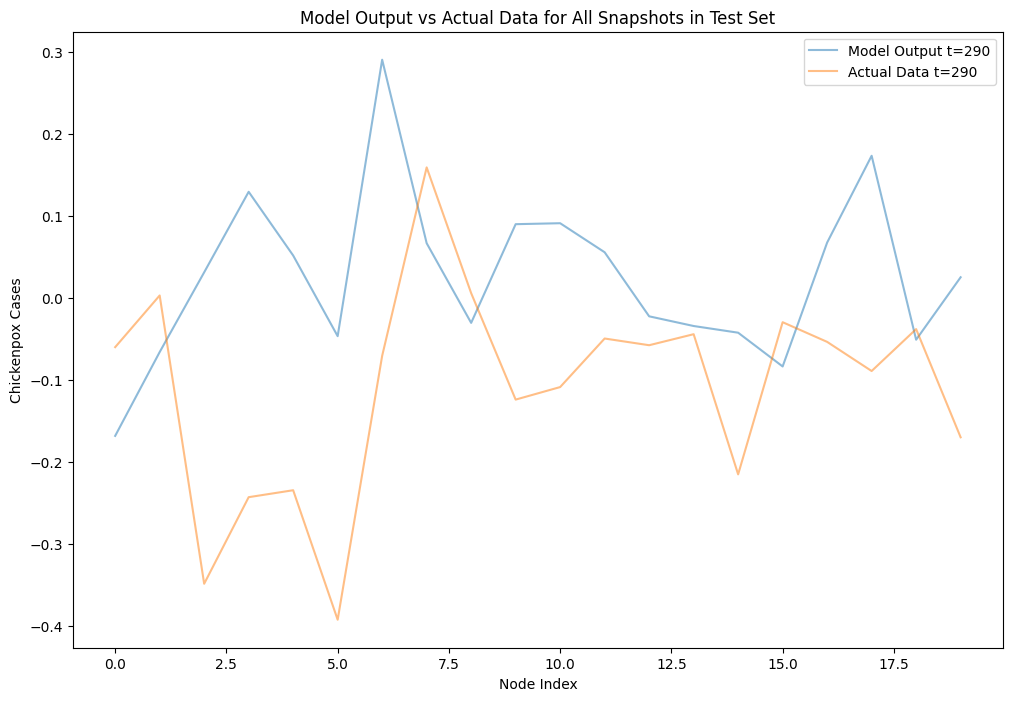

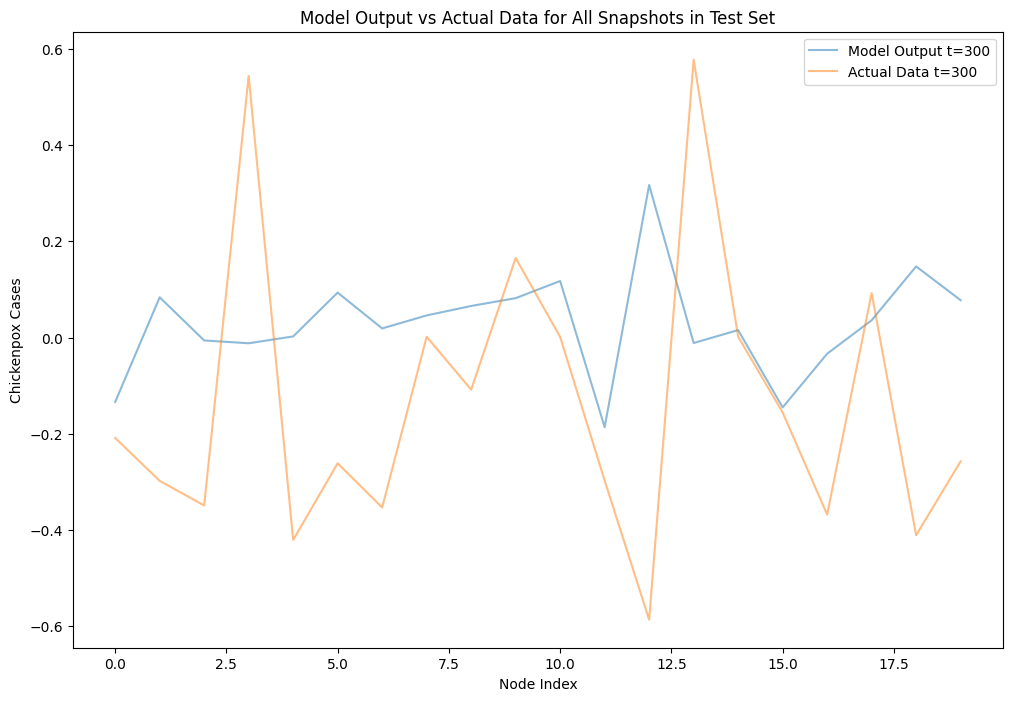

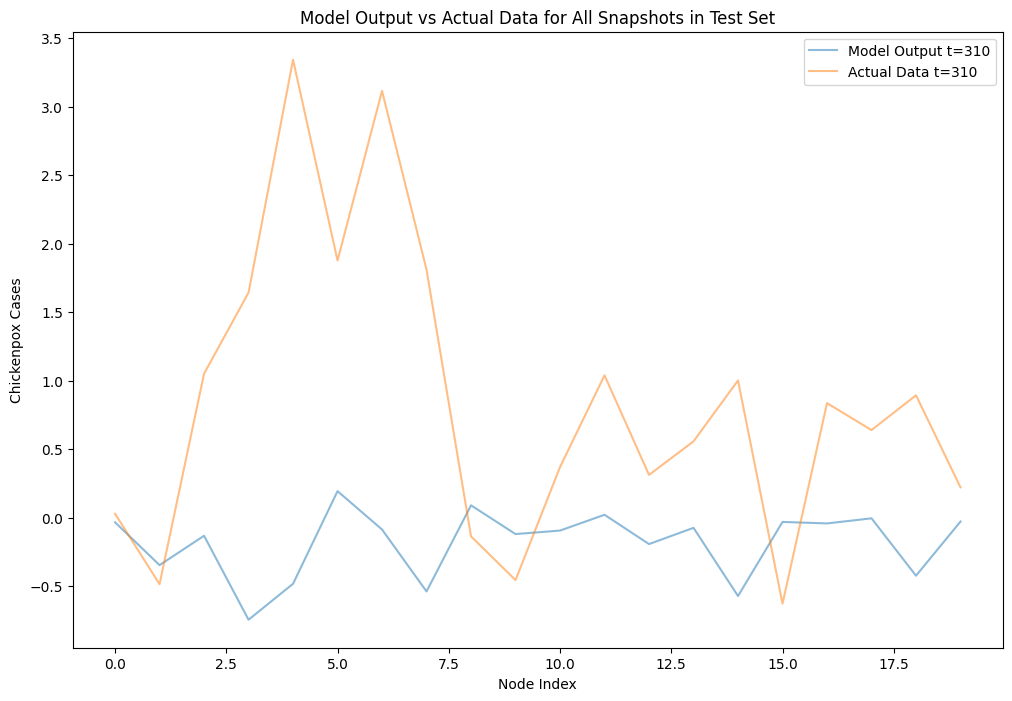

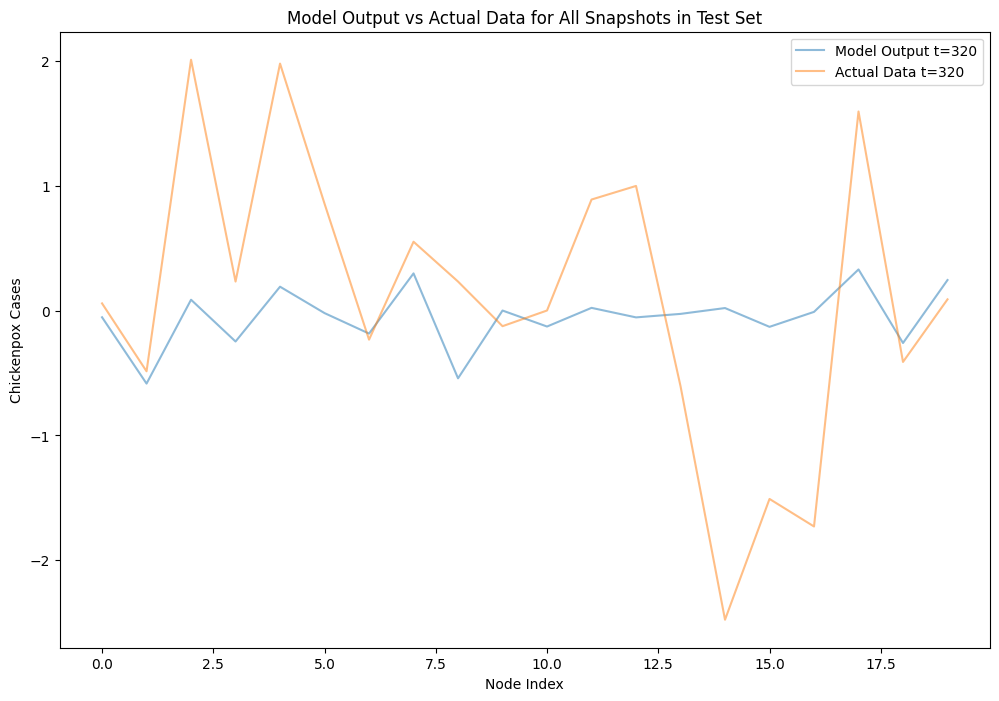

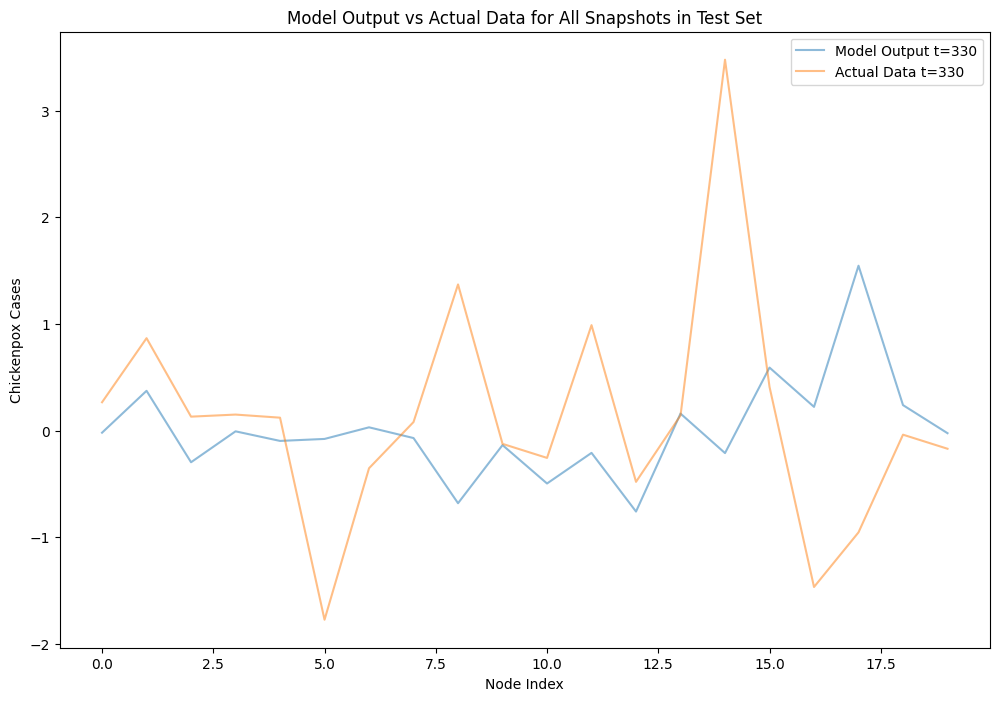

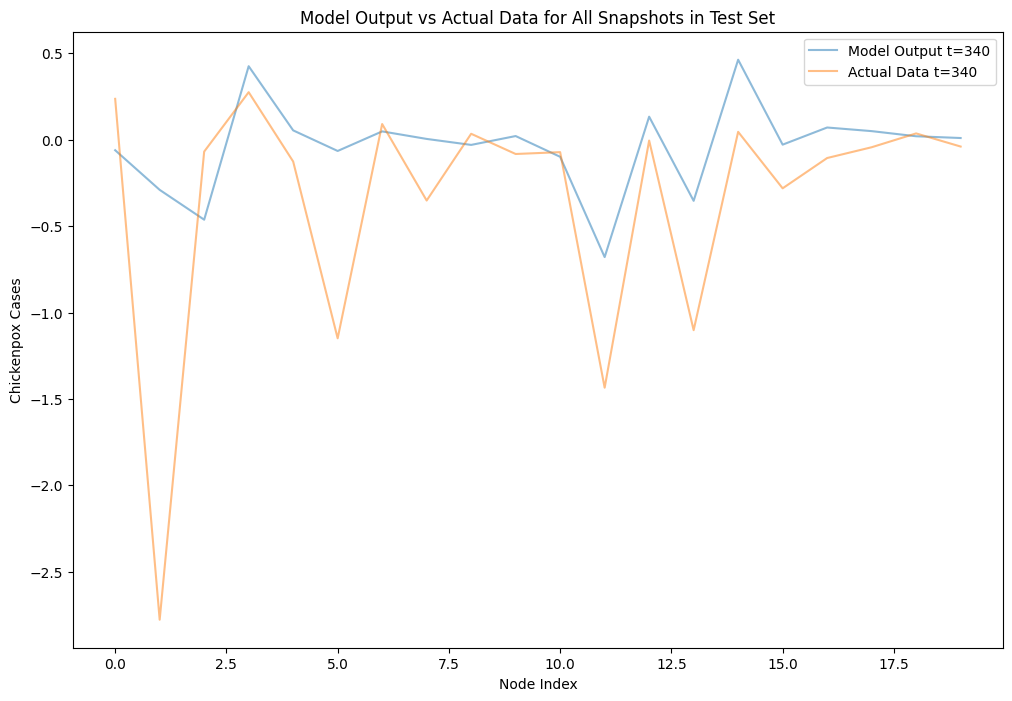

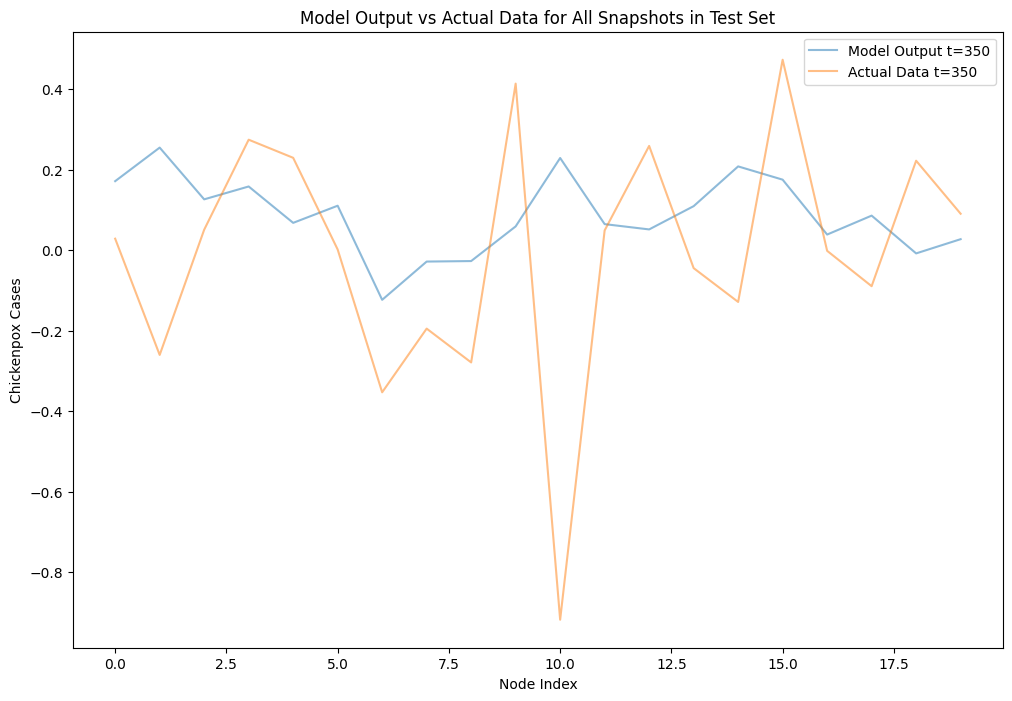

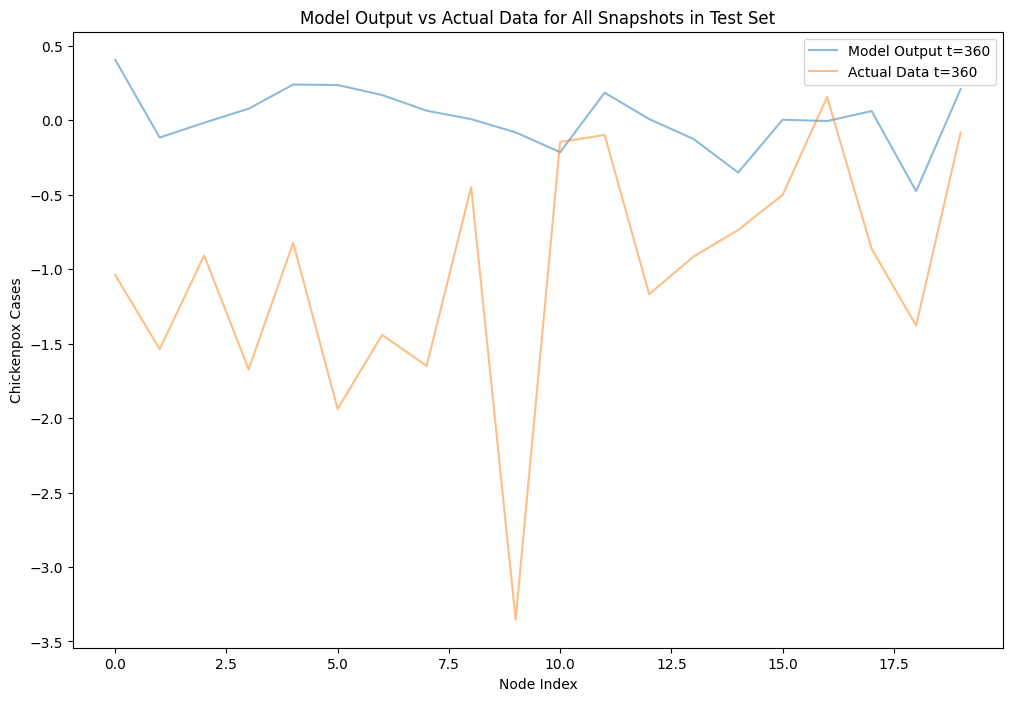

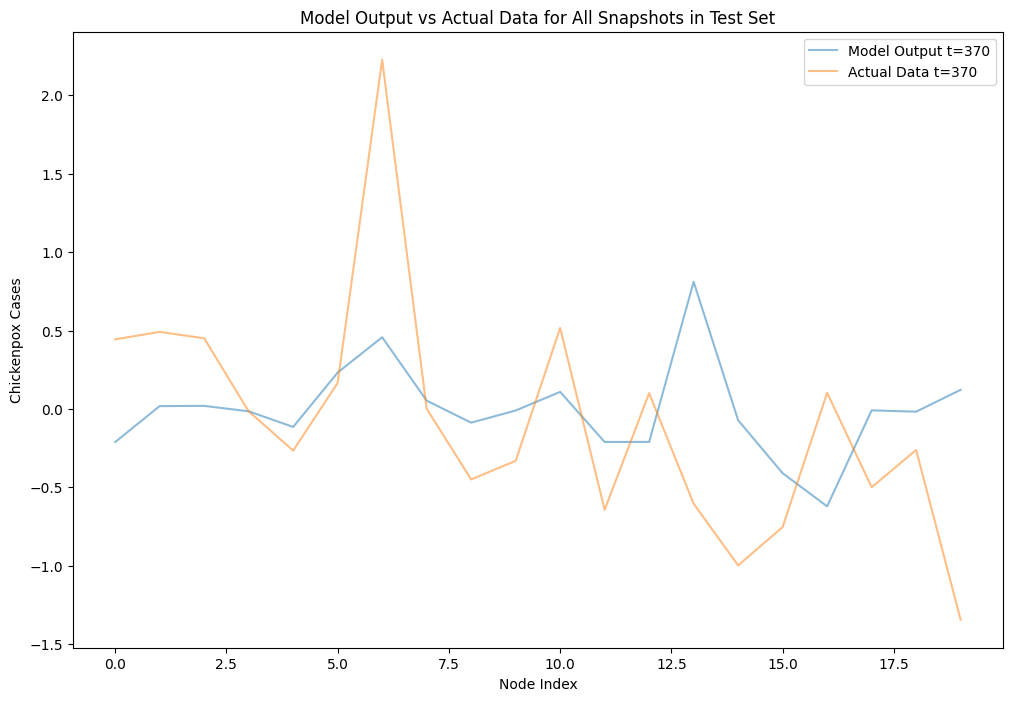

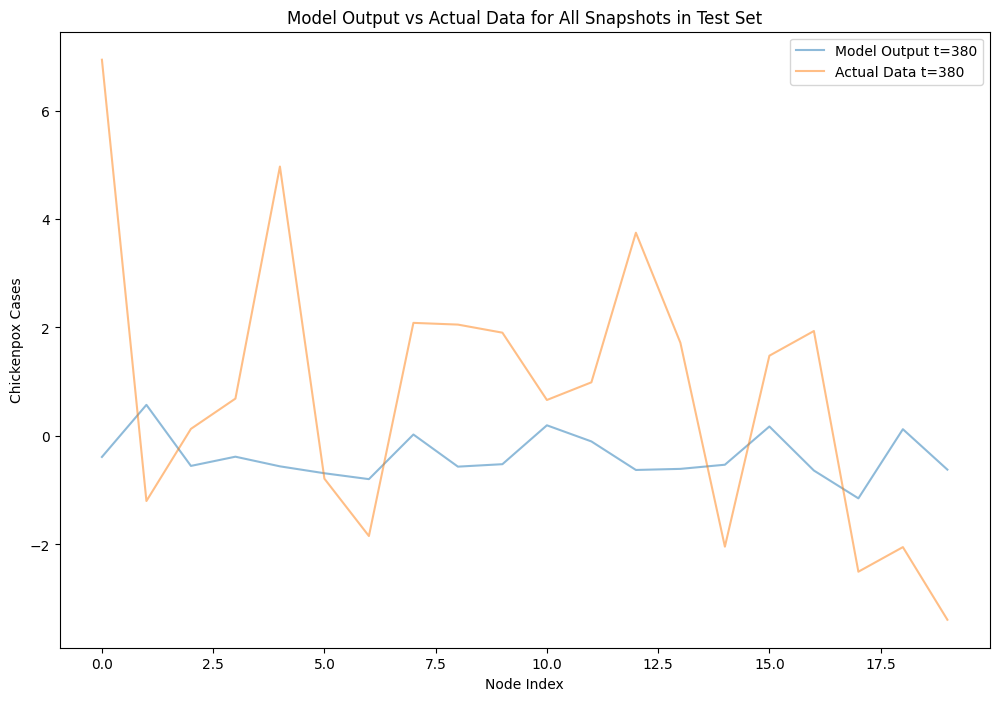

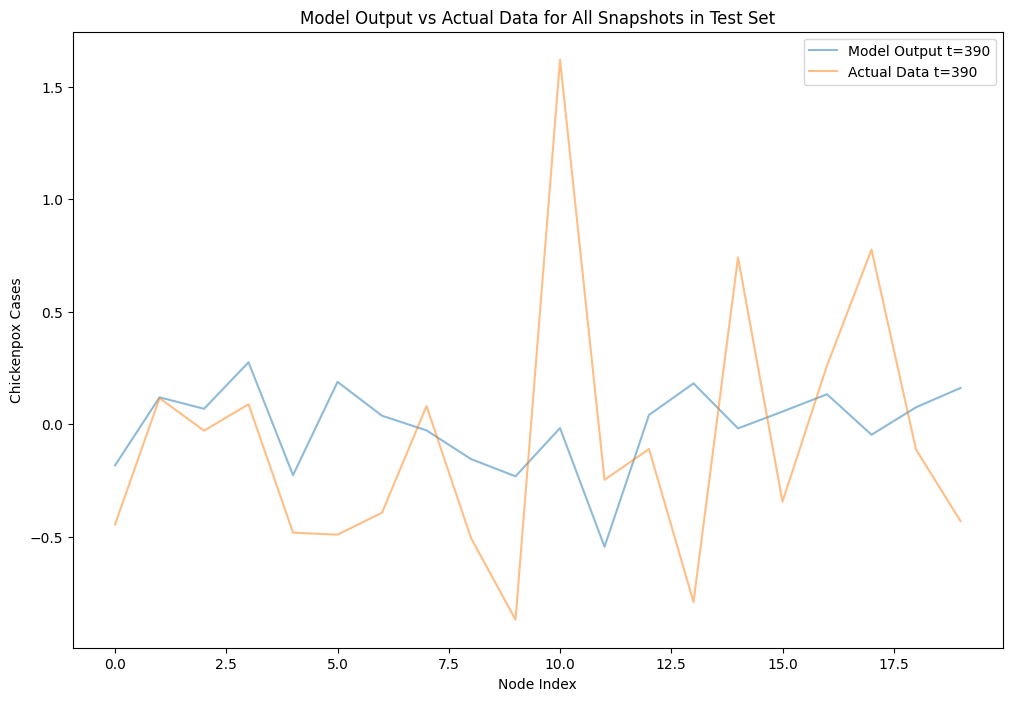

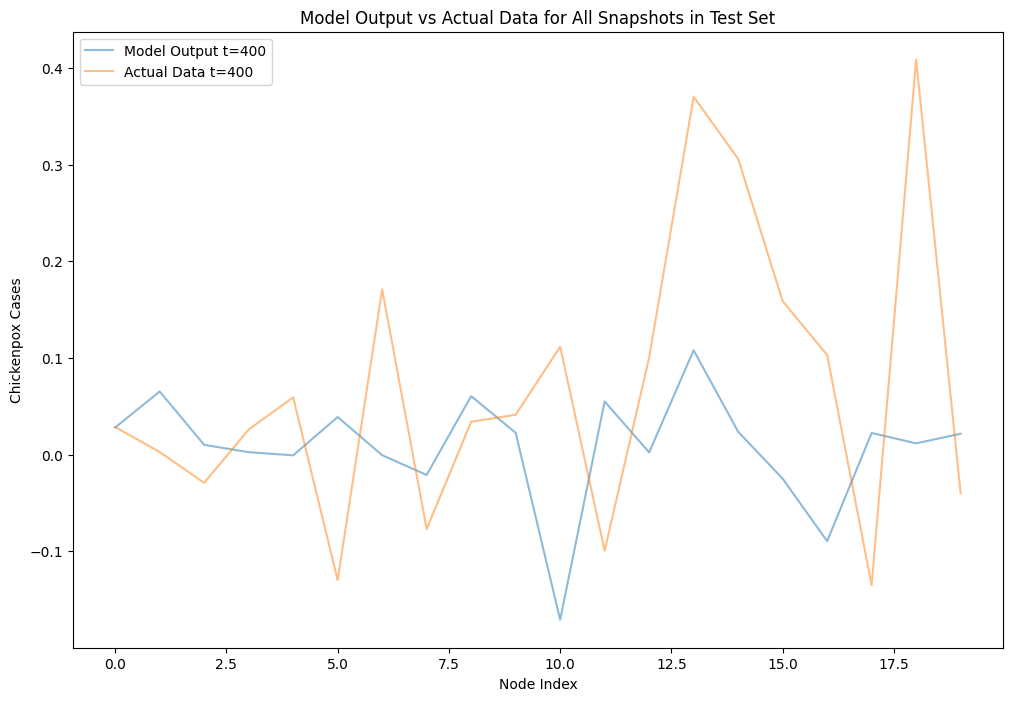

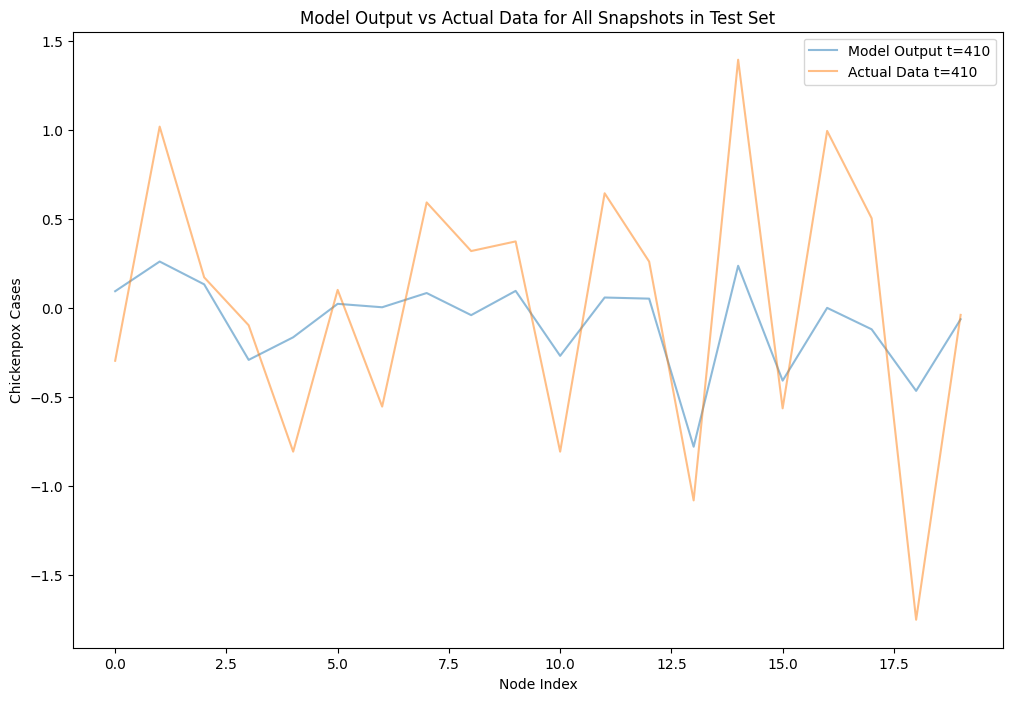

In [ ]:
# # Plot model output vs actual data for the last snapshot in the test set
# plt.figure(figsize=(10,6))
# plt.plot(y_hat.detach().cpu().numpy(), label='Model Output', marker='o')
# plt.plot(snapshot.y.detach().cpu().numpy(), label='Actual Data', marker='x')
# plt.xlabel('Node Index')
# plt.ylabel('Chickenpox Cases')
# plt.title('Model Output vs Actual Data')
# plt.legend()
# plt.show()

# Plot all snapshots in the test set

for time, snapshot in enumerate(test_dataset):
    if time % 10 != 0:
        continue  # Plot every 10th snapshot to reduce number of plots
    plt.figure(figsize=(12,8))
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    plt.plot(y_hat.detach().cpu().numpy(), label=f'Model Output t={time}', alpha=0.5)
    plt.plot(snapshot.y.detach().cpu().numpy(), label=f'Actual Data t={time}', alpha=0.5)
    plt.xlabel('Node Index')
    plt.ylabel('Chickenpox Cases')
    plt.title('Model Output vs Actual Data for All Snapshots in Test Set')
    plt.legend()
    plt.show()  